In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gc
import json
import time
import shutil
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink, Image
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset, random_split,TensorDataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize
from moviepy.editor import VideoFileClip
from scipy import sum, average
import random
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

In [ ]:
data = pd.read_csv("/kaggle/input/wlasl-processed/videos.csv")
data.rename(columns = {'video_name_folder': 'video_name', 'gloss': 'tag'}, inplace = True)
data.drop(columns=['Unnamed: 0','image_id','train_test', 'url'], inplace = True)
data['video_name'] = data['video_name'].apply(lambda x: '/kaggle/input/wlasl-processed/videos' + x)
data

tag                                         video_name
0         book  /content/drive/MyDrive/Machine Learning Projec...
1         book  /content/drive/MyDrive/Machine Learning Projec...
2         book  /content/drive/MyDrive/Machine Learning Projec...
3         book  /content/drive/MyDrive/Machine Learning Projec...
4         book  /content/drive/MyDrive/Machine Learning Projec...
...        ...                                                ...
21078  whistle  /content/drive/MyDrive/Machine Learning Projec...
21079  whistle  /content/drive/MyDrive/Machine Learning Projec...
21080  whistle  /content/drive/MyDrive/Machine Learning Projec...
21081  whistle  /content/drive/MyDrive/Machine Learning Projec...
21082  whistle  /content/drive/MyDrive/Machine Learning Projec...

[21083 rows x 2 columns]

In [ ]:
NUM_WORDS = 10
LOWER_THRESHOLD = 15
UPPER_THRESHOLD = 20

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 12
EPOCHS = 100
MAX_SEQ_LENGTH = 90

In [ ]:
tag_counts = data['tag'].value_counts()
tags_to_keep = tag_counts[(tag_counts > LOWER_THRESHOLD) & (tag_counts < UPPER_THRESHOLD)].index
data = data[data['tag'].isin(tags_to_keep)]
unique_tags = data['tag'].unique()
selected_tags = np.random.choice(unique_tags, size=NUM_WORDS, replace=False)
# selected_tags = ['all', 'hearing', 'cheat', 'right', 'water', 'bar', 'red', 'copy', 'late', 'window']
data = data[data['tag'].isin(selected_tags)]

In [ ]:
train_df, test_df = train_test_split(data, test_size = 0.2, train_size = 0.8, stratify= data['tag'])

In [ ]:
def save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, max_frames, model):
    save_dir = f"/content/drive/MyDrive/ML Project /PreprocessedData/{model}"
    os.makedirs(save_dir, exist_ok=True)

    tags_str = '_'.join(selected_tags)
    filename = f"data_{tags_str}_{max_frames}_frames.npz"
    filepath = os.path.join(save_dir, filename)

    np.savez_compressed(filepath,
                        train_data_0=train_data[0],
                        train_data_1=train_data[1],
                        train_labels=train_labels,
                        test_data_0=test_data[0],
                        test_data_1=test_data[1],
                        test_labels=test_labels)
    print(f"Preprocessed data saved to {filepath}")
def load_preprocessed_data(selected_tags, max_frames, model):
    save_dir = f"/content/drive/MyDrive/ML Project /PreprocessedData/{model}"
    tags_str = '_'.join(selected_tags)
    filename = f"data_{tags_str}_{max_frames}_frames.npz"
    filepath = os.path.join(save_dir, filename)

    if not os.path.exists(filepath):
        print(f"No preprocessed data found for tags {selected_tags} with {max_frames} frames.")
        return None

    # Load the data
    data = np.load(filepath)
    train_data = (data['train_data_0'], data['train_data_1'])
    test_data = (data['test_data_0'], data['test_data_1'])
    train_labels = data['train_labels']
    test_labels = data['test_labels']
    print(f"Preprocessed data loaded from {filepath}")

    return train_data, train_labels, test_data, test_labels

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor(model_name):
    if model_name == 'VGG16':
        feature_extractor = keras.applications.VGG16(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.vgg16.preprocess_input

    elif model_name == 'InceptionV3':
        feature_extractor = keras.applications.InceptionV3(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.inception_v3.preprocess_input

    elif model_name == 'ResNet50':
        feature_extractor = keras.applications.ResNet50(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.resnet.preprocess_input

    elif model_name == 'EfficientNetV2L':
        feature_extractor = keras.applications.EfficientNetV2L(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.efficientnet_v2.preprocess_input
    elif model_name == 'InceptionResNetV2':
        feature_extractor = keras.applications.InceptionResNetV2(
            weights="imagenet",
            include_top=False,
            pooling="avg",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )
        preprocess_input = keras.applications.inception_resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


In [ ]:
feature_extractor_InceptionV3 = build_feature_extractor('InceptionV3')
feature_extractor_ResNet50 = build_feature_extractor('ResNet50')
feature_extractor_EfficientNetV2L = build_feature_extractor('EfficientNetV2L')
feature_extractor_VGG16 = build_feature_extractor('VGG16')
feature_extractor_InceptionResNetV2 = build_feature_extractor('InceptionResNetV2')

219055592/219055592 [==============================] - 1s 0us/step


Here we convert string labels to numerical indices for model training using StringLookup layer

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['all', 'bar', 'cheat', 'copy', 'hearing', 'late', 'red', 'right', 'water', 'window']


In [ ]:
def prepare_all_videos(df, root_dir, model, feature_extractor, NUM_FEATURES):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(tqdm.tqdm((video_paths))):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            start = int(max((length//2)-(MAX_SEQ_LENGTH/2), 0))
            stop = int(min(((length//2)+(MAX_SEQ_LENGTH/2)),length))
            for j in range(start,stop):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
models = ['InceptionV3', 'ResNet50', 'EfficientNetV2L', 'VGG16', 'InceptionResNetV2']
NUM_FEATURES = [2048, 2048, 1280, 512, 1536]

train_data, train_labels = prepare_all_videos(train_df, "train", models[0], feature_extractor_InceptionV3, NUM_FEATURES[0])
test_data, test_labels = prepare_all_videos(test_df, "test", models[0], feature_extractor_InceptionV3, NUM_FEATURES[0])
save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, MAX_SEQ_LENGTH, models[0])

train_data, train_labels = prepare_all_videos(train_df, "train", models[1], feature_extractor_ResNet50, NUM_FEATURES[1])
test_data, test_labels = prepare_all_videos(test_df, "test", models[1], feature_extractor_ResNet50, NUM_FEATURES[1])
save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, MAX_SEQ_LENGTH, models[1])

train_data, train_labels = prepare_all_videos(train_df, "train", models[2], feature_extractor_EfficientNetV2L NUM_FEATURES[2])
test_data, test_labels = prepare_all_videos(test_df, "test", models[2], feature_extractor_EfficientNetV2L, NUM_FEATURES[2])
save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, MAX_SEQ_LENGTH, models[2])

train_data, train_labels = prepare_all_videos(train_df, "train", models[3], feature_extractor_VGG16, NUM_FEATURES[3])
test_data, test_labels = prepare_all_videos(test_df, "test", models[3], feature_extractor_VGG16, NUM_FEATURES[3])
save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, MAX_SEQ_LENGTH, models[3])

train_data, train_labels = prepare_all_videos(train_df, "train", models[4], feature_extractor_InceptionResNetV2, NUM_FEATURES[4])
test_data, test_labels = prepare_all_videos(test_df, "test", models[4], feature_extractor_InceptionResNetV2, NUM_FEATURES[4])
save_preprocessed_data(train_data, train_labels, test_data, test_labels, selected_tags, MAX_SEQ_LENGTH, models[4])


  0%|          | 0/141 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 1/141 [00:10<23:56, 10.26s/it]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 2/141 [00:14<15:28,  6.68s/it]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 3/141 [00:21<16:03,  6.98s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 4/141 [00:25<13:06,  5.74s/it]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 5/141 [00:30<12:43,  5.61s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 6/141 [00:33<10:19,  4.59s/it]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 7/141 [00:38<10:34,  4.74s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 8/141 [00:41<08:51,  4.00s/it]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 9/141 [00:46<09:52,  4.49s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 10/141 [00:51<09:45,  4.47s/it]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 11/141 [00:56<10:07,  4.67s/it]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 12/141 [01:00<09:57,  4.63s/it]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 13/141 [01:04<09:23,  4.40s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 14/141 [01:11<10:45,  5.08s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 15/141 [01:17<11:32,  5.50s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 16/141 [01:22<11:01,  5.29s/it]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 17/141 [01:28<11:38,  5.63s/it]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 18/141 [01:34<11:12,  5.47s/it]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 19/141 [01:37<10:08,  4.99s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 20/141 [01:42<09:37,  4.77s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 21/141 [01:49<11:02,  5.52s/it]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 22/141 [01:53<10:07,  5.10s/it]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 23/141 [01:59<10:23,  5.28s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 24/141 [02:03<09:36,  4.92s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 25/141 [02:09<10:24,  5.39s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 26/141 [02:14<09:40,  5.05s/it]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 27/141 [02:20<10:06,  5.32s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 28/141 [02:26<10:32,  5.60s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 29/141 [02:29<09:23,  5.03s/it]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 30/141 [02:35<09:36,  5.20s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 31/141 [02:41<09:57,  5.43s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 32/141 [02:48<10:57,  6.03s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 33/141 [02:54<10:45,  5.97s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 34/141 [02:58<09:12,  5.16s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 35/141 [03:04<09:31,  5.39s/it]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 36/141 [03:08<09:01,  5.16s/it]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 37/141 [03:12<08:26,  4.87s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 38/141 [03:18<08:38,  5.04s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 39/141 [03:27<10:35,  6.23s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 40/141 [03:33<10:32,  6.26s/it]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 41/141 [03:38<09:35,  5.76s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 42/141 [03:44<09:35,  5.82s/it]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 43/141 [03:50<09:52,  6.04s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 44/141 [03:56<09:28,  5.86s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 45/141 [04:02<09:47,  6.12s/it]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 46/141 [04:09<09:57,  6.29s/it]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 47/141 [04:16<10:14,  6.54s/it]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 48/141 [04:21<09:20,  6.03s/it]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 49/141 [04:29<09:59,  6.52s/it]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 50/141 [04:33<08:56,  5.89s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 51/141 [04:38<08:13,  5.48s/it]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 52/141 [04:41<07:24,  4.99s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 53/141 [04:46<07:18,  4.99s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 54/141 [04:51<06:52,  4.74s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 55/141 [04:57<07:22,  5.14s/it]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 56/141 [05:00<06:26,  4.54s/it]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 57/141 [05:06<06:55,  4.94s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 58/141 [05:11<07:05,  5.13s/it]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 59/141 [05:15<06:27,  4.72s/it]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 60/141 [05:20<06:38,  4.92s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 61/141 [05:25<06:18,  4.73s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 62/141 [05:29<06:12,  4.72s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 63/141 [05:37<07:09,  5.51s/it]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 64/141 [05:39<05:59,  4.66s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 65/141 [05:45<06:08,  4.84s/it]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 66/141 [05:50<06:02,  4.83s/it]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 67/141 [05:53<05:36,  4.55s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 68/141 [05:57<05:16,  4.33s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 69/141 [06:02<05:10,  4.32s/it]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 70/141 [06:08<05:52,  4.97s/it]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 71/141 [06:12<05:23,  4.63s/it]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 72/141 [06:18<05:54,  5.13s/it]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 73/141 [06:23<05:35,  4.93s/it]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 74/141 [06:30<06:24,  5.74s/it]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 75/141 [06:35<05:50,  5.31s/it]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 76/141 [06:40<05:51,  5.40s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 77/141 [06:45<05:37,  5.27s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 78/141 [06:52<06:11,  5.89s/it]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 79/141 [06:57<05:42,  5.53s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 80/141 [07:01<05:01,  4.94s/it]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 81/141 [07:08<05:36,  5.62s/it]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 82/141 [07:13<05:26,  5.54s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 83/141 [07:21<05:51,  6.06s/it]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 84/141 [07:23<04:40,  4.92s/it]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 85/141 [07:28<04:35,  4.92s/it]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 86/141 [07:31<04:10,  4.56s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 87/141 [07:37<04:24,  4.90s/it]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 88/141 [07:41<04:03,  4.60s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 89/141 [07:46<04:02,  4.66s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 90/141 [07:51<04:05,  4.82s/it]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 91/141 [07:57<04:12,  5.05s/it]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 92/141 [08:03<04:33,  5.58s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 93/141 [08:16<06:01,  7.54s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 94/141 [08:22<05:32,  7.07s/it]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 95/141 [08:28<05:22,  7.01s/it]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 96/141 [08:34<04:51,  6.47s/it]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 97/141 [08:36<03:54,  5.32s/it]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 98/141 [08:42<03:53,  5.42s/it]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 99/141 [08:46<03:29,  4.98s/it]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 100/141 [08:50<03:09,  4.62s/it]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 101/141 [08:56<03:20,  5.02s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 102/141 [09:00<03:04,  4.73s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 103/141 [09:03<02:42,  4.28s/it]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 104/141 [09:09<03:01,  4.92s/it]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 105/141 [09:14<02:50,  4.73s/it]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 106/141 [09:19<02:50,  4.87s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 107/141 [09:24<02:44,  4.85s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 108/141 [09:30<02:53,  5.27s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 109/141 [09:33<02:27,  4.61s/it]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 110/141 [09:37<02:16,  4.39s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 111/141 [09:41<02:10,  4.34s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 112/141 [09:46<02:11,  4.53s/it]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 113/141 [09:52<02:22,  5.08s/it]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 114/141 [09:58<02:21,  5.25s/it]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 115/141 [10:03<02:12,  5.10s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 116/141 [10:09<02:14,  5.38s/it]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 117/141 [10:16<02:21,  5.90s/it]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 118/141 [10:22<02:14,  5.86s/it]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 119/141 [10:26<01:59,  5.45s/it]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 120/141 [10:31<01:51,  5.32s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 121/141 [10:34<01:34,  4.73s/it]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 122/141 [10:41<01:40,  5.31s/it]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 123/141 [10:48<01:42,  5.71s/it]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 124/141 [10:54<01:41,  5.96s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 125/141 [10:58<01:25,  5.35s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 126/141 [11:03<01:18,  5.26s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 127/141 [11:10<01:20,  5.75s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 128/141 [11:16<01:13,  5.68s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 129/141 [11:21<01:07,  5.59s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 130/141 [11:27<01:01,  5.61s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 131/141 [11:34<01:01,  6.16s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 132/141 [11:42<00:59,  6.56s/it]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 133/141 [11:47<00:48,  6.03s/it]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 134/141 [11:51<00:39,  5.64s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 135/141 [11:55<00:30,  5.12s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 136/141 [11:59<00:23,  4.62s/it]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 137/141 [12:06<00:22,  5.59s/it]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 138/141 [12:11<00:15,  5.19s/it]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 139/141 [12:17<00:11,  5.58s/it]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 140/141 [12:23<00:05,  5.50s/it]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 1/36 [00:06<03:47,  6.50s/it]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 2/36 [00:13<03:46,  6.66s/it]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 3/36 [00:18<03:25,  6.22s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 4/36 [00:26<03:37,  6.79s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 5/36 [00:30<03:03,  5.91s/it]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 6/36 [00:35<02:38,  5.28s/it]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 7/36 [00:42<02:50,  5.89s/it]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 8/36 [00:49<02:58,  6.36s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 9/36 [00:55<02:45,  6.13s/it]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 10/36 [00:58<02:17,  5.28s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 11/36 [01:01<01:53,  4.54s/it]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 12/36 [01:07<02:00,  5.04s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 13/36 [01:10<01:38,  4.28s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 14/36 [01:13<01:31,  4.14s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 15/36 [01:21<01:47,  5.10s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 16/36 [01:25<01:37,  4.86s/it]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 17/36 [01:30<01:32,  4.85s/it]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 18/36 [01:35<01:27,  4.84s/it]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 19/36 [01:39<01:19,  4.67s/it]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 20/36 [01:44<01:15,  4.72s/it]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 21/36 [01:50<01:16,  5.07s/it]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 22/36 [01:54<01:07,  4.84s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 23/36 [02:01<01:13,  5.63s/it]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 24/36 [02:05<01:00,  5.01s/it]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 25/36 [02:13<01:04,  5.86s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 26/36 [02:19<00:58,  5.81s/it]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 27/36 [02:26<00:56,  6.31s/it]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 28/36 [02:31<00:47,  5.88s/it]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 29/36 [02:36<00:38,  5.52s/it]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 30/36 [02:41<00:33,  5.61s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 31/36 [02:46<00:27,  5.44s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 32/36 [02:49<00:18,  4.66s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 33/36 [02:56<00:15,  5.14s/it]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 34/36 [02:58<00:08,  4.35s/it]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 35/36 [03:03<00:04,  4.46s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 36/36 [03:06<00:00,  5.18s/it]


Preprocessed data saved to /content/drive/MyDrive/ML Project Kristian/PreprocessedData/InceptionV3/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz
Frame features in train set: (141, 90, 2048)
Frame masks in train set: (141, 90)
Frame features in train set: (141, 90, 2048)
Frame masks in train set: (141, 90)


We now load the data which we just processed.

In [ ]:
models = ['InceptionV3', 'ResNet50', 'EfficientNetV2L', 'VGG16', 'InceptionResNetV2']
train_data_IV, train_labels_IV, test_data_IV, test_labels_IV = load_preprocessed_data(selected_tags, 90, models[0])
train_data_RN, train_labels_RN, test_data_RN, test_labels_RN = load_preprocessed_data(selected_tags, 90, models[1])
train_data_EN, train_labels_EN, test_data_EN, test_labels_EN = load_preprocessed_data(selected_tags, 90, models[2])
train_data_VG, train_labels_VG, test_data_VG, test_labels_VG = load_preprocessed_data(selected_tags, 90, models[3])
train_data_IR, train_labels_IR, test_data_IR, test_labels_IR = load_preprocessed_data(selected_tags, 90, models[4])

Preprocessed data loaded from /content/drive/MyDrive/ML Project Kristian/PreprocessedData/InceptionV3/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz
Preprocessed data loaded from /content/drive/MyDrive/ML Project Kristian/PreprocessedData/ResNet50/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz
Preprocessed data loaded from /content/drive/MyDrive/ML Project Kristian/PreprocessedData/EfficientNetV2L/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz
Preprocessed data loaded from /content/drive/MyDrive/ML Project Kristian/PreprocessedData/VGG16/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz
Preprocessed data loaded from /content/drive/MyDrive/ML Project Kristian/PreprocessedData/InceptionResNetV2/data_all_hearing_cheat_right_water_bar_red_copy_late_window_90_frames.npz


We now define a function to plot the results

In [ ]:
def plot_metrics(history, baseline, model, seq_length, num_words, EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(epochs, history.history['val_sparse_top_k_categorical_accuracy'], label='Validation Top-3 Accuracy')
    plt.title(f'Validation Accuracy, {baseline}, {model} Model, {seq_length} frames, {num_words} words, {EPOCHS} epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss, {baseline}, {model} Model, {seq_length} frames, {num_words} words, {EPOCHS} epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print(f"Max Top-3 Categorical Accuracy reached: {max(history.history['val_sparse_top_k_categorical_accuracy'])*100}")
    print(f"Max Accuracy reached: {max(history.history['val_accuracy'])*100}")

## **InceptionV3**

### **GRUs Model**

### **Bidirectional Model**

In [ ]:
NUM_FEATURES_IV = 2048
def get_bidirectional_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IV))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True))(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.Bidirectional(keras.layers.GRU(8))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    bd_model = get_bidirectional_model()
    history = bd_model.fit(
        [train_data_IV[0], train_data_IV[1]],
        train_labels_IV,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = bd_model.evaluate([test_data_IV[0], test_data_IV[1]], test_labels_IV)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, bd_model

# Run the experiment
history_IV_bd, bd_model = run_experiment()


Epoch 1/25
4/4 [==============================] - 19s 2s/step - loss: 2.4767 - accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.4184 - val_loss: 2.3131 - val_accuracy: 0.1395 - val_sparse_top_k_categorical_accuracy: 0.4419
Epoch 2/25
4/4 [==============================] - 0s 50ms/step - loss: 2.3384 - accuracy: 0.1327 - sparse_top_k_categorical_accuracy: 0.4796 - val_loss: 2.3056 - val_accuracy: 0.0465 - val_sparse_top_k_categorical_accuracy: 0.4419
Epoch 3/25
4/4 [==============================] - 0s 45ms/step - loss: 2.3049 - accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.4694 - val_loss: 2.3048 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.3721
Epoch 4/25
4/4 [==============================] - 0s 48ms/step - loss: 2.3261 - accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.5000 - val_loss: 2.3050 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.3953
Epoch 5/25
4/4 [==============================] - 0s 47ms/step - loss

### **Self Attention Model**

### **Transformer Model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)


    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)
    return keras.Model([inputs, mask_input], outputs)

# Build and compile the model
def get_transformer_model():
    input_shape = (MAX_SEQ_LENGTH, NUM_FEATURES_IV)
    transformer_model = build_transformer_model(
        input_shape,
        head_size=256,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[64], # 64 IS BEST SO FAR
        dropout=0.5,
        mlp_dropout=0.5
    )
    optimizer = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)
    # optimizer = keras.optimizers.Nadam(learning_rate=1e-4, clipnorm=1.0)
    transformer_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return transformer_model

def run_experiment():
    transformer_model = get_transformer_model()
    history = transformer_model.fit(
        [train_data_IV[0], train_data_IV[1]],
        train_labels_IV,
        validation_split=0.2,
        epochs=25,
        batch_size=64,
        callbacks=[tensorboard_callback]
    )

    _, accuracy, top_k_accuracy = transformer_model.evaluate([test_data_IV[0], test_data_IV[1]], test_labels_IV)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")

    # Get predictions
    predictions = transformer_model.predict([test_data_IV[0], test_data_IV[1]])

    # Compute the argmax to get predicted class labels
    predicted_labels = np.argmax(predictions, axis=-1)

    # Calculate the accuracy on the predicted labels
    accuracy_on_predicted = accuracy_score(test_labels_IV, predicted_labels)
    print(f"Accuracy on predicted labels: {round(accuracy_on_predicted * 100, 2)}%")

    return history, transformer_model

# Assuming train_data, train_labels, test_data, and test_labels are already prepared
history_IV_trans, trans_model = run_experiment()

Epoch 1/25
2/2 [==============================] - 16s 2s/step - loss: 2.5495 - accuracy: 0.1161 - sparse_top_k_categorical_accuracy: 0.5089 - val_loss: 2.4115 - val_accuracy: 0.0690 - val_sparse_top_k_categorical_accuracy: 0.4483
Epoch 2/25
2/2 [==============================] - 1s 1s/step - loss: 2.2938 - accuracy: 0.1607 - sparse_top_k_categorical_accuracy: 0.5982 - val_loss: 2.3809 - val_accuracy: 0.0690 - val_sparse_top_k_categorical_accuracy: 0.4483
Epoch 3/25
2/2 [==============================] - 1s 1s/step - loss: 2.0937 - accuracy: 0.2321 - sparse_top_k_categorical_accuracy: 0.7143 - val_loss: 2.4317 - val_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.4828
Epoch 4/25
2/2 [==============================] - 1s 1s/step - loss: 2.0618 - accuracy: 0.2411 - sparse_top_k_categorical_accuracy: 0.7411 - val_loss: 2.3524 - val_accuracy: 0.1034 - val_sparse_top_k_categorical_accuracy: 0.5517
Epoch 5/25
2/2 [==============================] - 1s 1s/step - loss: 1.8991 - a

In [ ]:
class AttentionLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = keras.backend.tanh(keras.backend.dot(x, self.W) + self.b)
        a = keras.backend.softmax(e, axis=1)
        output = x * a
        return keras.backend.sum(output, axis=1)
def get_att_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IV))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")


    x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.02)))(frame_features_input, mask=mask_input)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.02)))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.02)))(x)
    x = keras.layers.Dropout(0.)(x)

    x = AttentionLayer()(x)  # Adding the attention layer here

    x = keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.02))(x)
    x = keras.layers.BatchNormalization()(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    att_model = keras.Model([frame_features_input, mask_input], output)
    # optimizer = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)
    optimizer = keras.optimizers.Nadam(learning_rate=1e-4, clipnorm=1.0)
    att_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return att_model

def run_experiment():
    att_model = get_att_model()
    history = att_model.fit(
        [train_data_IV[0], train_data_IV[1]],
        train_labels_IV,
        validation_split=0.2,
        epochs=EPOCHS_ATT,
        batch_size=32
    )
    _, accuracy, top_k_accuracy = att_model.evaluate([test_data_IV[0], test_data_IV[1]], test_labels_IV)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    # Get predictions
    predictions = att_model.predict([test_data_IV[0], test_data_IV[1]])

    # Compute the argmax to get predicted class labels
    predicted_labels = np.argmax(predictions, axis=-1)

    # Calculate the accuracy on the predicted labels
    accuracy_on_predicted = accuracy_score(test_labels_IV, predicted_labels)
    print(f"Accuracy on predicted labels: {round(accuracy_on_predicted * 100, 2)}%")
    return history, att_model

history_IV_att, att_model = run_experiment()

Epoch 1/100
4/4 [==============================] - 34s 2s/step - loss: 42.5258 - accuracy: 0.0714 - sparse_top_k_categorical_accuracy: 0.4464 - val_loss: 41.9396 - val_accuracy: 0.0690 - val_sparse_top_k_categorical_accuracy: 0.4483
Epoch 2/100
4/4 [==============================] - 0s 62ms/step - loss: 41.8979 - accuracy: 0.1429 - sparse_top_k_categorical_accuracy: 0.5625 - val_loss: 41.5923 - val_accuracy: 0.0690 - val_sparse_top_k_categorical_accuracy: 0.4138
Epoch 3/100
4/4 [==============================] - 0s 60ms/step - loss: 41.3711 - accuracy: 0.2232 - sparse_top_k_categorical_accuracy: 0.6786 - val_loss: 41.1660 - val_accuracy: 0.0690 - val_sparse_top_k_categorical_accuracy: 0.4828
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 40.7584 - accuracy: 0.2768 - sparse_top_k_categorical_accuracy: 0.7411 - val_loss: 40.7505 - val_accuracy: 0.0345 - val_sparse_top_k_categorical_accuracy: 0.4138
Epoch 5/100
4/4 [==============================] - 0s 61ms/step -

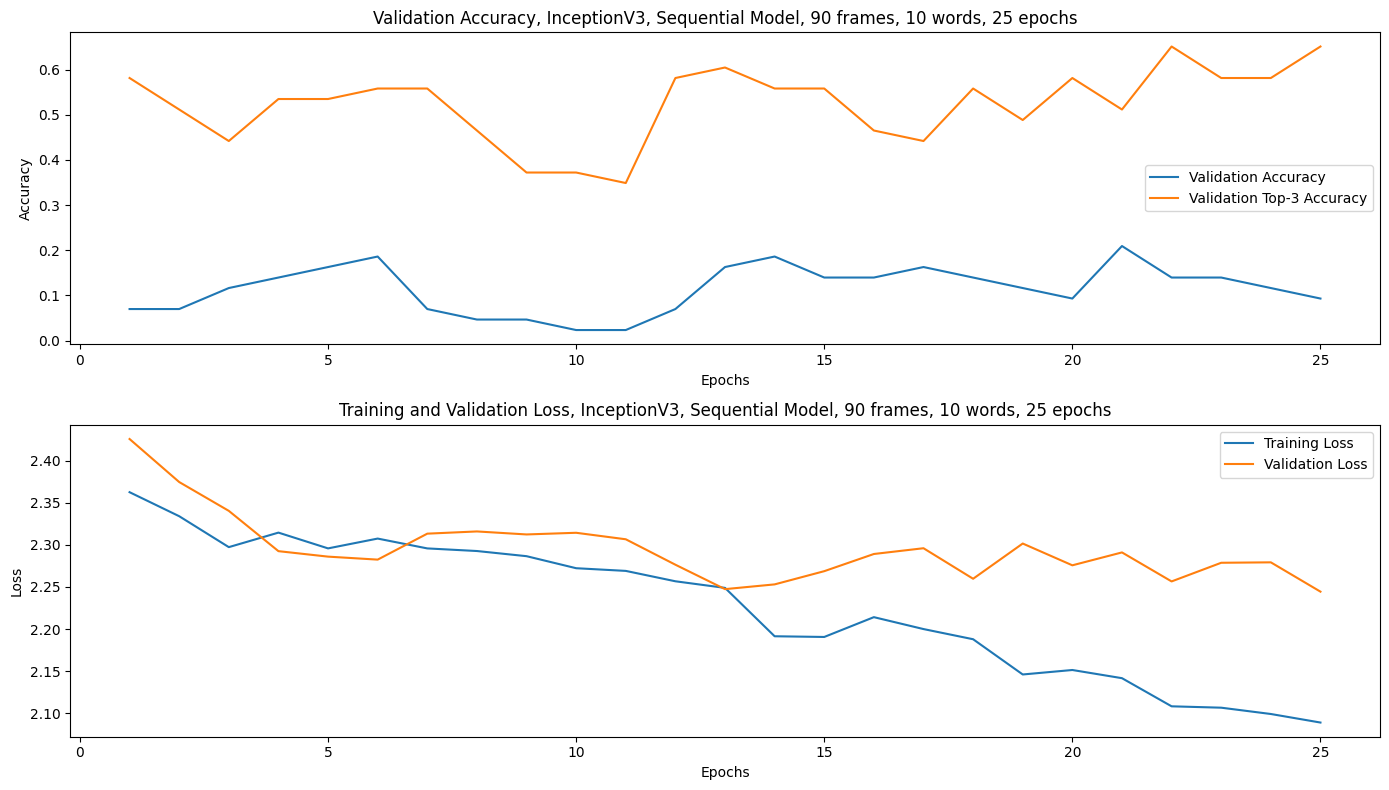

Max Top-3 Categorical Accuracy reached: 65.11628031730652
Max Accuracy reached: 20.930232107639313


In [ ]:
plot_metrics(history_IV_seq, "InceptionV3", "Sequential", MAX_SEQ_LENGTH, NUM_WORDS, EPOCHS)

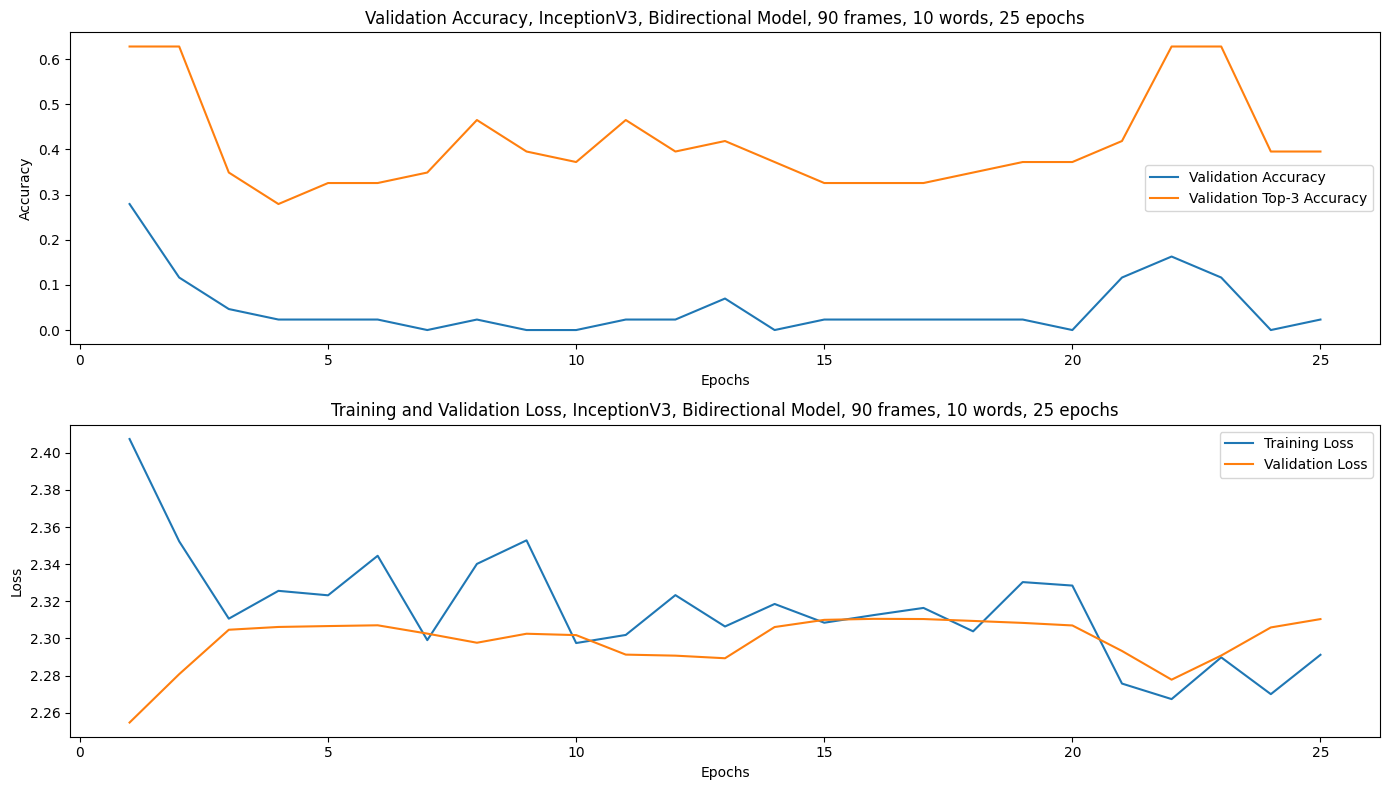

Max Top-3 Categorical Accuracy reached: 62.79069781303406
Max Accuracy reached: 27.906978130340576


In [ ]:
plot_metrics(history_IV_bd, "InceptionV3", "Bidirectional", MAX_SEQ_LENGTH, NUM_WORDS, EPOCHS)

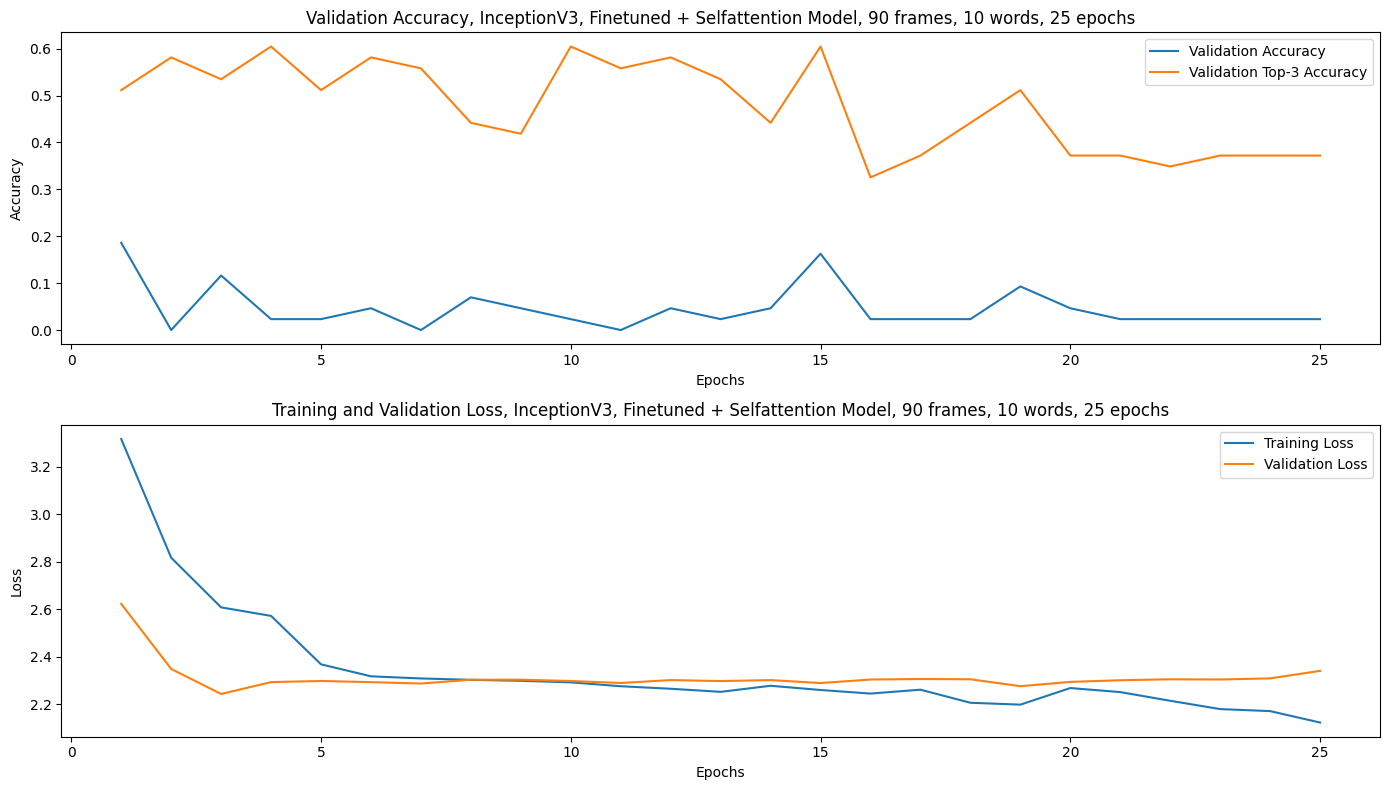

Max Top-3 Categorical Accuracy reached: 60.4651153087616
Max Accuracy reached: 18.60465109348297


In [ ]:
plot_metrics(history_IV_fine, "InceptionV3", "Finetuned + Selfattention", MAX_SEQ_LENGTH, NUM_WORDS, EPOCHS)

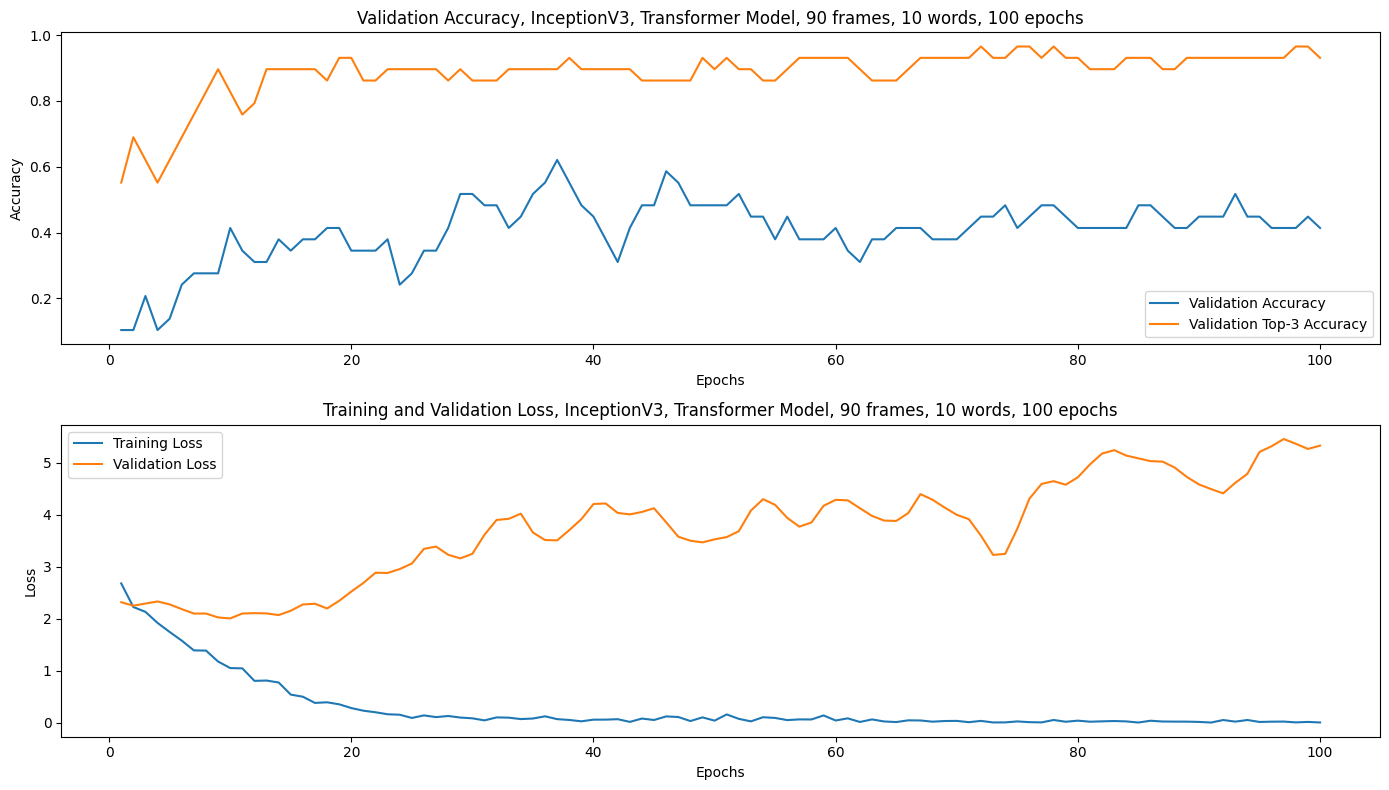

Max Top-3 Categorical Accuracy reached: 96.55172228813171
Max Accuracy reached: 62.068963050842285


In [ ]:
plot_metrics(history_IV_trans, "InceptionV3", "Transformer", MAX_SEQ_LENGTH, NUM_WORDS, 100)

## **ResNet50**

### **GRUs Model**

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_RN))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=
         [keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None),
          keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy", dtype=None)
          ])
    return rnn_model


# Utility for running experiments.
def run_experiment():

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data_RN[0], train_data_RN[1]],
        train_labels_RN,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_crossentropy = seq_model.evaluate([test_data_RN[0], test_data_RN[1]], test_labels_RN)
    print(f"Test accuracy: {round(accuracy*100, 2)}%")
    print(f"Test Top 5 Categorical Cross Entropy: {round(top_crossentropy*100, 2)}%")
    return history, seq_model


history_RN_seq, RN_sequence_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 9s 760ms/step - loss: 2.4052 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.3163 - val_loss: 2.2883 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.4186
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 2.3115 - sparse_categorical_accuracy: 0.1429 - sparse_top_k_categorical_accuracy: 0.3061 - val_loss: 2.3073 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.3488
Epoch 3/50
4/4 [==============================] - 0s 36ms/step - loss: 2.2832 - sparse_categorical_accuracy: 0.1633 - sparse_top_k_categorical_accuracy: 0.3469 - val_loss: 2.3314 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 4/50
4/4 [==============================] - 0s 36ms/step - loss: 2.2746 - sparse_categorical_accuracy: 0.1837 - sparse_top_k_categorical_accuracy: 0.3673 - val_loss: 2.3027 - val_sparse_

### **Bidirectional Model**

In [ ]:
def get_bidirectional_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_RN))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True))(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.Bidirectional(keras.layers.GRU(8))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    bd_model = get_bidirectional_model()
    history = bd_model.fit(
        [train_data_IV[0], train_data_IV[1]],
        train_labels_IV,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = bd_model.evaluate([test_data_RN[0], test_data_RN[1]], test_labels_RN)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, bd_model

# Run the experiment
history_RN_bd, RN_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 18s 1s/step - loss: 2.4141 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.2959 - val_loss: 2.3170 - val_sparse_categorical_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.3488
Epoch 2/50
4/4 [==============================] - 0s 47ms/step - loss: 2.3319 - sparse_categorical_accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.3367 - val_loss: 2.3119 - val_sparse_categorical_accuracy: 0.0465 - val_sparse_top_k_categorical_accuracy: 0.3023
Epoch 3/50
4/4 [==============================] - 0s 49ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.3265 - val_loss: 2.3255 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 4/50
4/4 [==============================] - 0s 47ms/step - loss: 2.2978 - sparse_categorical_accuracy: 0.1531 - sparse_top_k_categorical_accuracy: 0.3367 - val_loss: 2.3796 - val_sparse_ca

### **Self Attention Model**

In [ ]:
def get_fine_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IV))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Convolutional Layers
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(frame_features_input)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    # MultiHead Attention
    x = keras.layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.5)(x, x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Flatten()(x)

    # MLP
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation='relu')(x)

    # Output Layer
    output = keras.layers.Dense(len(class_vocab), activation='softmax')(x)


    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    fine_model = get_fine_model()
    history = fine_model.fit(
        [train_data_RN[0], train_data_RN[1]],
        train_labels_RN,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = fine_model.evaluate([test_data_RN[0], test_data_RN[1]], test_labels_RN)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, fine_model

# Run the experiment
history_RN_fine, fine_model = run_experiment()


Epoch 1/50
4/4 [==============================] - 5s 126ms/step - loss: 7.1307 - sparse_categorical_accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.2857 - val_loss: 5.4691 - val_sparse_categorical_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.3023
Epoch 2/50
4/4 [==============================] - 0s 32ms/step - loss: 10.4820 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.2755 - val_loss: 2.8230 - val_sparse_categorical_accuracy: 0.1163 - val_sparse_top_k_categorical_accuracy: 0.3721
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 3.9406 - sparse_categorical_accuracy: 0.0612 - sparse_top_k_categorical_accuracy: 0.3469 - val_loss: 2.8907 - val_sparse_categorical_accuracy: 0.0233 - val_sparse_top_k_categorical_accuracy: 0.2326
Epoch 4/50
4/4 [==============================] - 0s 31ms/step - loss: 2.9227 - sparse_categorical_accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.3673 - val_loss: 2.4238 - val_sparse

### **Transformer Model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)


    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)
    return keras.Model([inputs, mask_input], outputs)

# Build and compile the model
def get_transformer_model():
    input_shape = (MAX_SEQ_LENGTH, NUM_FEATURES_IV)
    transformer_model = build_transformer_model(
        input_shape,
        head_size=256,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[64], # 64 IS BEST SO FAR
        dropout=0.5,
        mlp_dropout=0.5
    )
    optimizer = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)
    transformer_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return transformer_model

def run_experiment():
    transformer_model = get_transformer_model()
    history = transformer_model.fit(
        [train_data_RN[0], train_data_RN[1]],
        train_labels_RN,
        validation_split=0.3,
        epochs=EPOCHS,  # Adjusted for demonstration purposes
        batch_size=32
    )

    _, accuracy, top_k_accuracy = fine_model.evaluate([test_data_RN[0], test_data_RN[1]], test_labels_RN)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, transformer_model

# Assuming train_data, train_labels, test_data, and test_labels are already prepared
history_RN_trans, trans_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 14s 271ms/step - loss: 2.5426 - sparse_categorical_accuracy: 0.0714 - sparse_top_k_categorical_accuracy: 0.2347 - val_loss: 2.4808 - val_sparse_categorical_accuracy: 0.0465 - val_sparse_top_k_categorical_accuracy: 0.2326
Epoch 2/50
4/4 [==============================] - 0s 87ms/step - loss: 2.3173 - sparse_categorical_accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.3673 - val_loss: 2.3129 - val_sparse_categorical_accuracy: 0.1860 - val_sparse_top_k_categorical_accuracy: 0.3488
Epoch 3/50
4/4 [==============================] - 0s 88ms/step - loss: 2.2451 - sparse_categorical_accuracy: 0.1327 - sparse_top_k_categorical_accuracy: 0.4082 - val_loss: 2.4316 - val_sparse_categorical_accuracy: 0.1163 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 4/50
4/4 [==============================] - 0s 87ms/step - loss: 2.1717 - sparse_categorical_accuracy: 0.1735 - sparse_top_k_categorical_accuracy: 0.4490 - val_loss: 2.4041 - val_sparse

plot_metrics(history_RN_seq, "ResNet50", "Sequential")

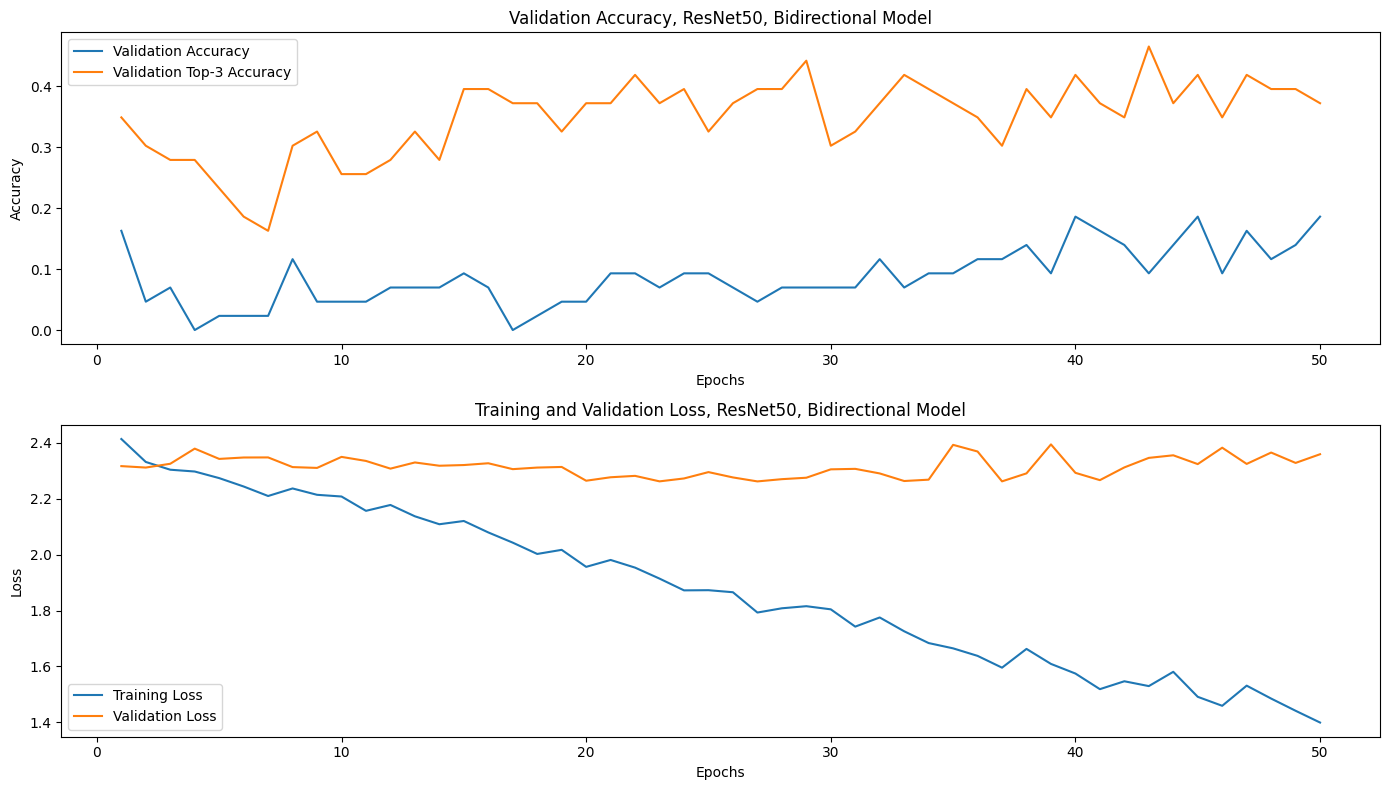

Max Top-3 Categorical Accuracy reached: 46.51162922382355
Max Sparse Categorical Accuracy reached: 18.60465109348297


In [ ]:
plot_metrics(history_RN_bd, "ResNet50", "Bidirectional")

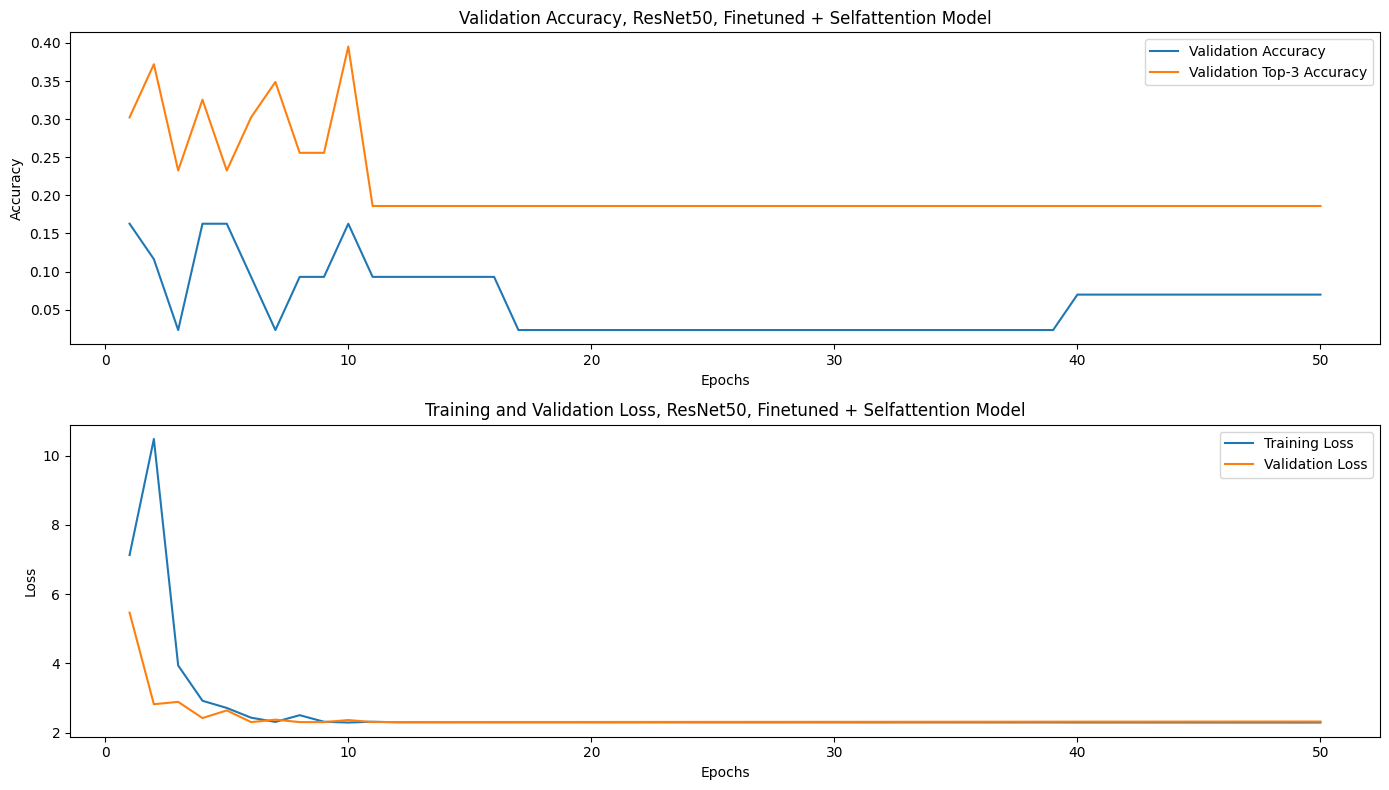

Max Top-3 Categorical Accuracy reached: 39.5348846912384
Max Sparse Categorical Accuracy reached: 16.27907007932663


In [ ]:
plot_metrics(history_RN_fine, "ResNet50", "Finetuned + Selfattention")

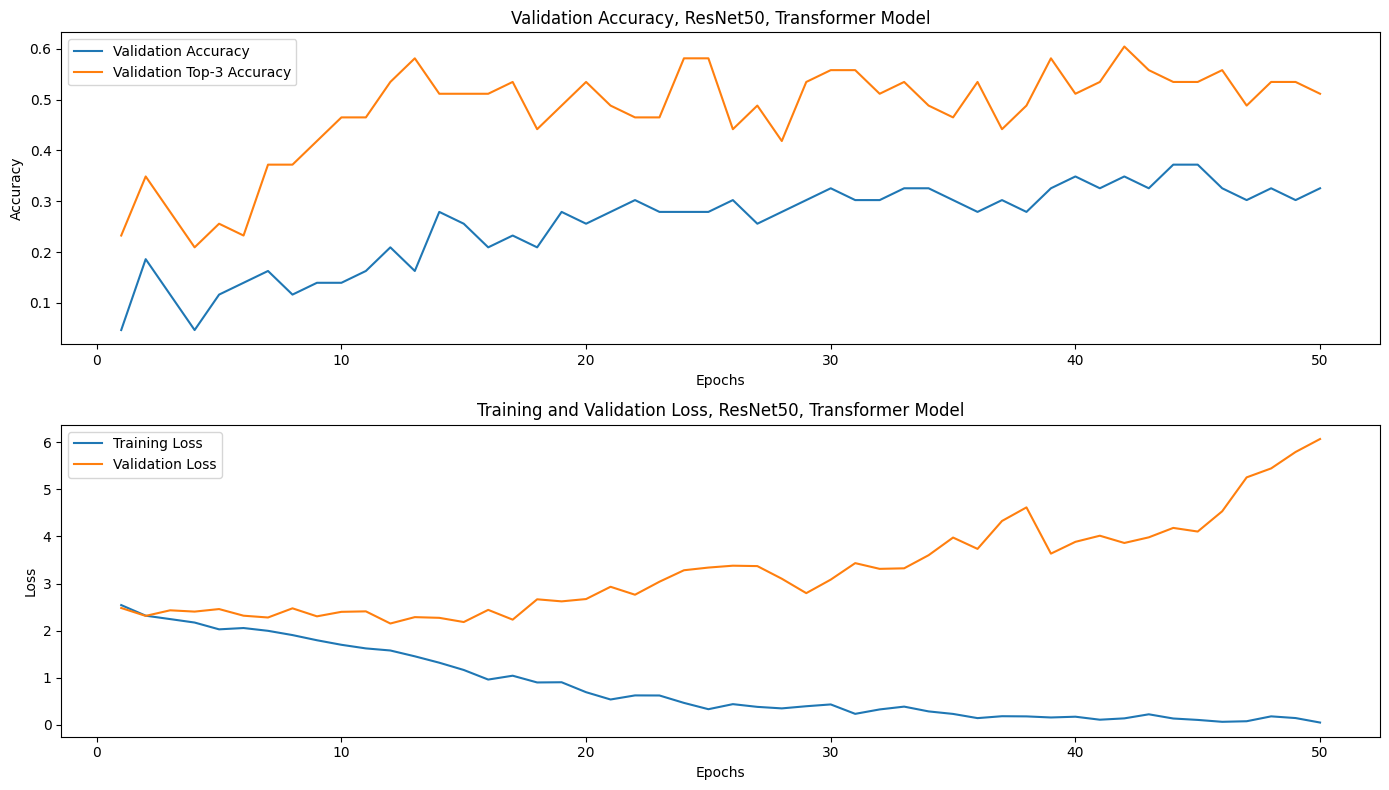

Max Top-3 Categorical Accuracy reached: 60.4651153087616
Max Sparse Categorical Accuracy reached: 37.20930218696594


In [ ]:
plot_metrics(history_RN_trans, "ResNet50", "Transformer")

## **EfficientNetV2L**

### **GRUs Model**

In [ ]:
NUM_FEATURES_EN = 1280
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_EN))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=
         [keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None),
          keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy", dtype=None)
          ])
    return rnn_model


# Utility for running experiments.
def run_experiment():

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data_EN[0], train_data_EN[1]],
        train_labels_EN,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_crossentropy = seq_model.evaluate([test_data_EN[0], test_data_EN[1]], test_labels_EN)
    print(f"Test accuracy: {round(accuracy*100, 2)}%")
    print(f"Test Top 5 Categorical Cross Entropy: {round(top_crossentropy*100, 2)}%")
    return history, seq_model


history_EN_seq, EN_sequence_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 9s 761ms/step - loss: 2.3345 - sparse_categorical_accuracy: 0.0816 - sparse_top_k_categorical_accuracy: 0.3061 - val_loss: 2.3062 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 2/50
4/4 [==============================] - 0s 32ms/step - loss: 2.2689 - sparse_categorical_accuracy: 0.1429 - sparse_top_k_categorical_accuracy: 0.3367 - val_loss: 2.3273 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.3023
Epoch 3/50
4/4 [==============================] - 0s 36ms/step - loss: 2.2802 - sparse_categorical_accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.3367 - val_loss: 2.3474 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.3023
Epoch 4/50
4/4 [==============================] - 0s 35ms/step - loss: 2.2485 - sparse_categorical_accuracy: 0.1429 - sparse_top_k_categorical_accuracy: 0.4184 - val_loss: 2.3527 - val_sparse_

### **Bidirectional Model**

### **Self Attention Model**

In [ ]:
def get_fine_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_EN))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Convolutional Layers
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(frame_features_input)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    # MultiHead Attention
    x = keras.layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.5)(x, x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Flatten()(x)

    # MLP
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation='relu')(x)

    # Output Layer
    output = keras.layers.Dense(len(class_vocab), activation='softmax')(x)


    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    fine_model = get_fine_model()
    history = fine_model.fit(
        [train_data_EN[0], train_data_EN[1]],
        train_labels_EN,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = fine_model.evaluate([test_data_EN[0], test_data_EN[1]], test_labels_EN)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, fine_model

# Run the experiment
history_EN_fine, fine_model = run_experiment()


Epoch 1/50
4/4 [==============================] - 5s 190ms/step - loss: 8.1503 - sparse_categorical_accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.3776 - val_loss: 3.9907 - val_sparse_categorical_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.5349
Epoch 2/50
4/4 [==============================] - 0s 28ms/step - loss: 8.3650 - sparse_categorical_accuracy: 0.1429 - sparse_top_k_categorical_accuracy: 0.3878 - val_loss: 3.5286 - val_sparse_categorical_accuracy: 0.1163 - val_sparse_top_k_categorical_accuracy: 0.3721
Epoch 3/50
4/4 [==============================] - 0s 28ms/step - loss: 4.4075 - sparse_categorical_accuracy: 0.1735 - sparse_top_k_categorical_accuracy: 0.4082 - val_loss: 2.6108 - val_sparse_categorical_accuracy: 0.0465 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 4/50
4/4 [==============================] - 0s 28ms/step - loss: 2.9396 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.3571 - val_loss: 2.3074 - val_sparse_

### **Transformer Model**

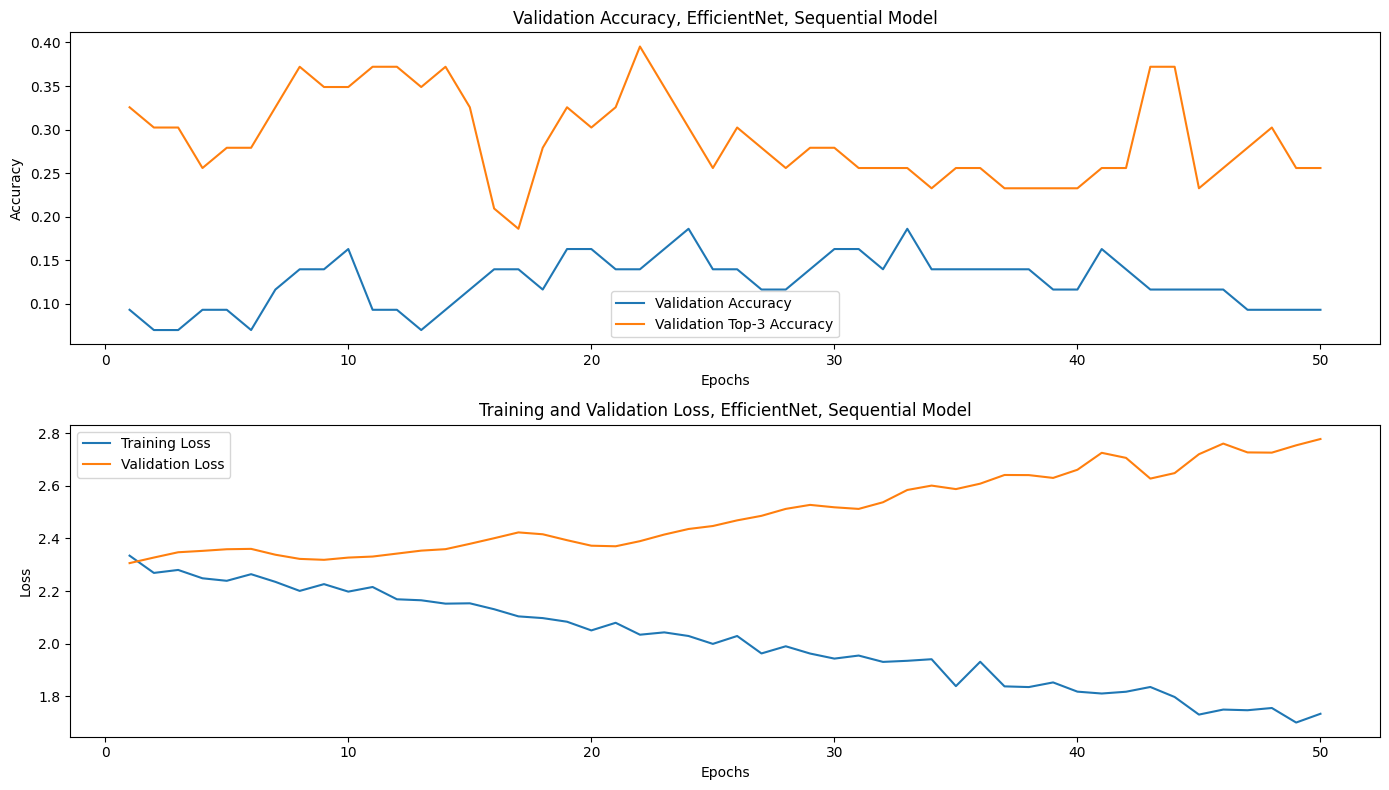

Max Top-3 Categorical Accuracy reached: 39.5348846912384
Max Sparse Categorical Accuracy reached: 18.60465109348297


In [ ]:
plot_metrics(history_EN_seq, "EfficientNet", "Sequential")

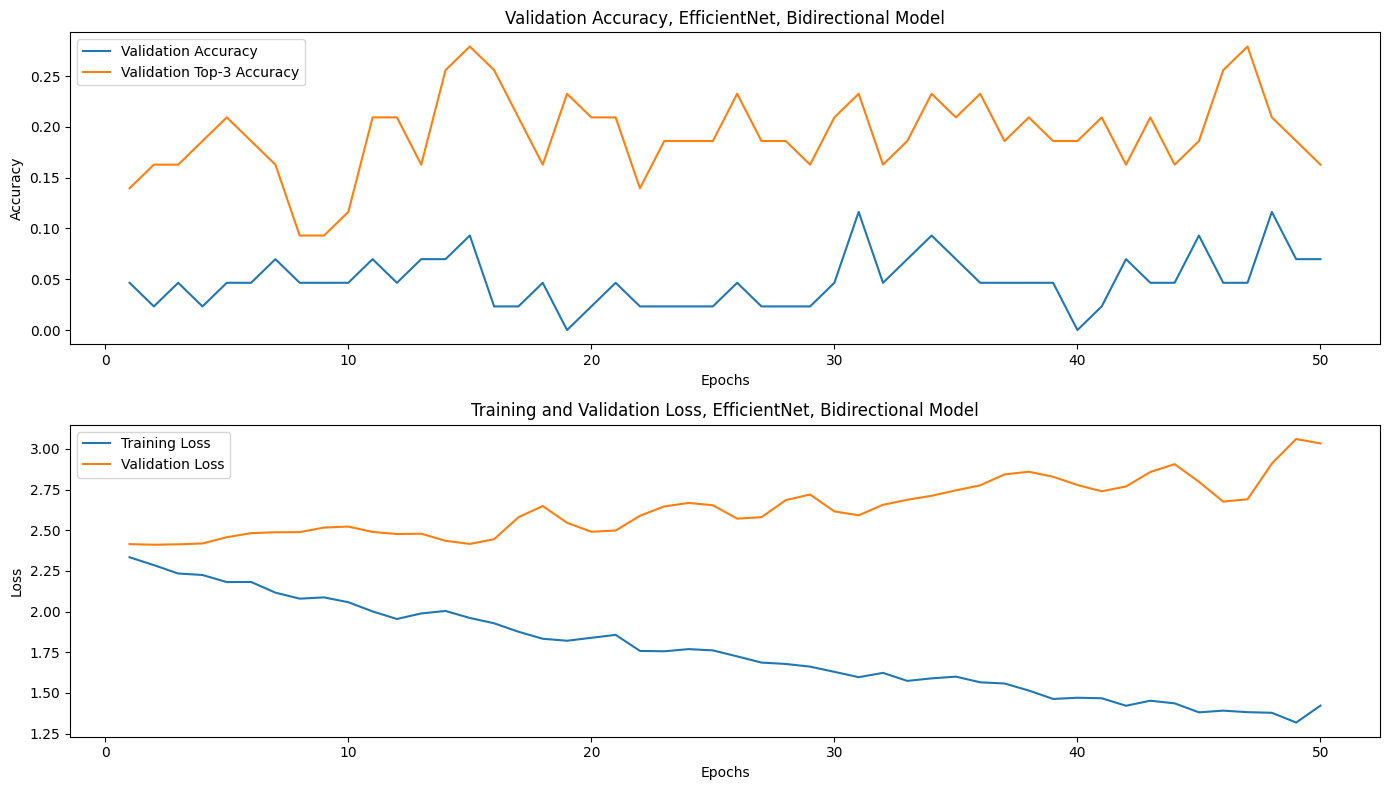

Max Top-3 Categorical Accuracy reached: 27.906978130340576
Max Sparse Categorical Accuracy reached: 11.627907305955887


In [ ]:
plot_metrics(history_EN_bd, "EfficientNet", "Bidirectional")

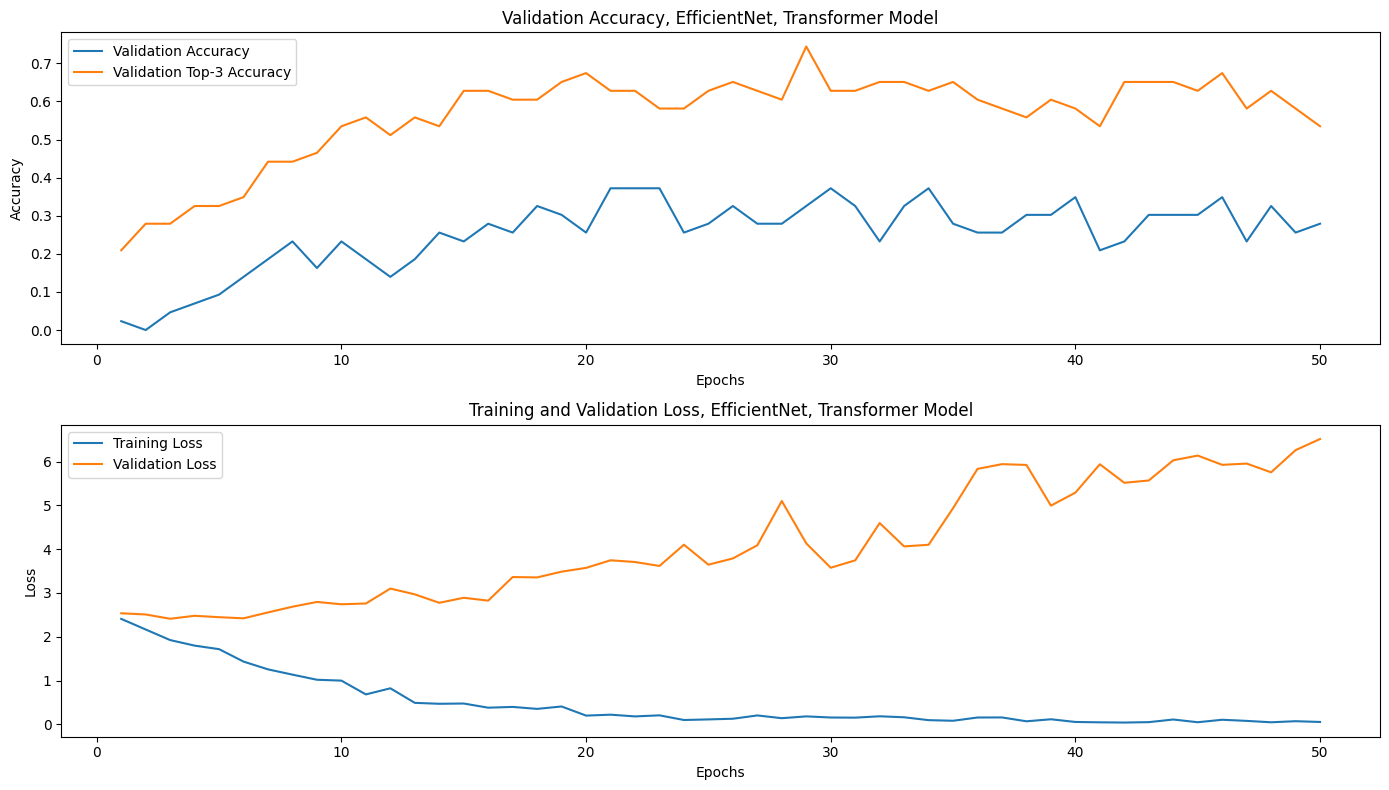

Max Top-3 Categorical Accuracy reached: 74.41860437393188
Max Sparse Categorical Accuracy reached: 37.20930218696594


In [ ]:
plot_metrics(history_EN_trans, "EfficientNet", "Transformer")

## **VGG16**

### **GRUs Model**

### **Bidirectional Model**

### **Self Attention Model**

### **Transformer Model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)


    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)
    return keras.Model([inputs, mask_input], outputs)

# Build and compile the model
def get_transformer_model():
    input_shape = (MAX_SEQ_LENGTH, NUM_FEATURES_VG)
    transformer_model = build_transformer_model(
        input_shape,
        head_size=256,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[64], # 64 IS BEST SO FAR
        dropout=0.5,
        mlp_dropout=0.5
    )
    optimizer = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)
    transformer_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return transformer_model

def run_experiment():
    transformer_model = get_transformer_model()
    history = transformer_model.fit(
        [train_data_VG[0], train_data_VG[1]],
        train_labels_VG,
        validation_split=0.3,
        epochs=EPOCHS,  # Adjusted for demonstration purposes
        batch_size=32
    )

    _, accuracy, top_k_accuracy = fine_model.evaluate([test_data_VG[0], test_data_VG[1]], test_labels_VG)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, transformer_model
# Assuming train_data, train_labels, test_data, and test_labels are already prepared
history_VG_trans, trans_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 14s 268ms/step - loss: 5.2785 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.3469 - val_loss: 3.1322 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 2/50
4/4 [==============================] - 0s 43ms/step - loss: 4.3107 - sparse_categorical_accuracy: 0.1327 - sparse_top_k_categorical_accuracy: 0.2653 - val_loss: 2.7813 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 3/50
4/4 [==============================] - 0s 41ms/step - loss: 3.0229 - sparse_categorical_accuracy: 0.1327 - sparse_top_k_categorical_accuracy: 0.3980 - val_loss: 2.6902 - val_sparse_categorical_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.2326
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 2.5997 - sparse_categorical_accuracy: 0.1531 - sparse_top_k_categorical_accuracy: 0.4082 - val_loss: 2.6323 - val_sparse

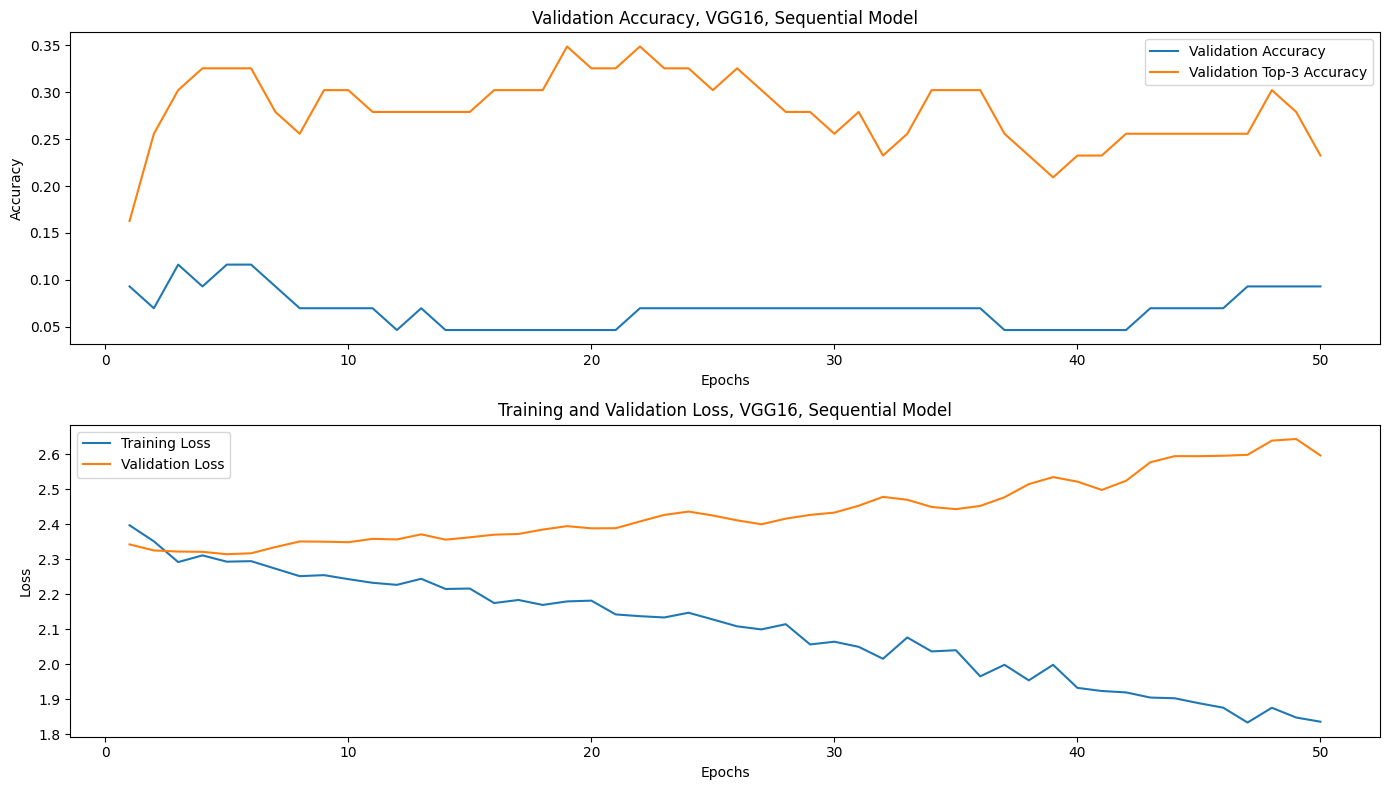

Max Top-3 Categorical Accuracy reached: 34.88371968269348
Max Sparse Categorical Accuracy reached: 11.627907305955887


In [ ]:
plot_metrics(history_VG_seq, "VGG16", "Sequential")

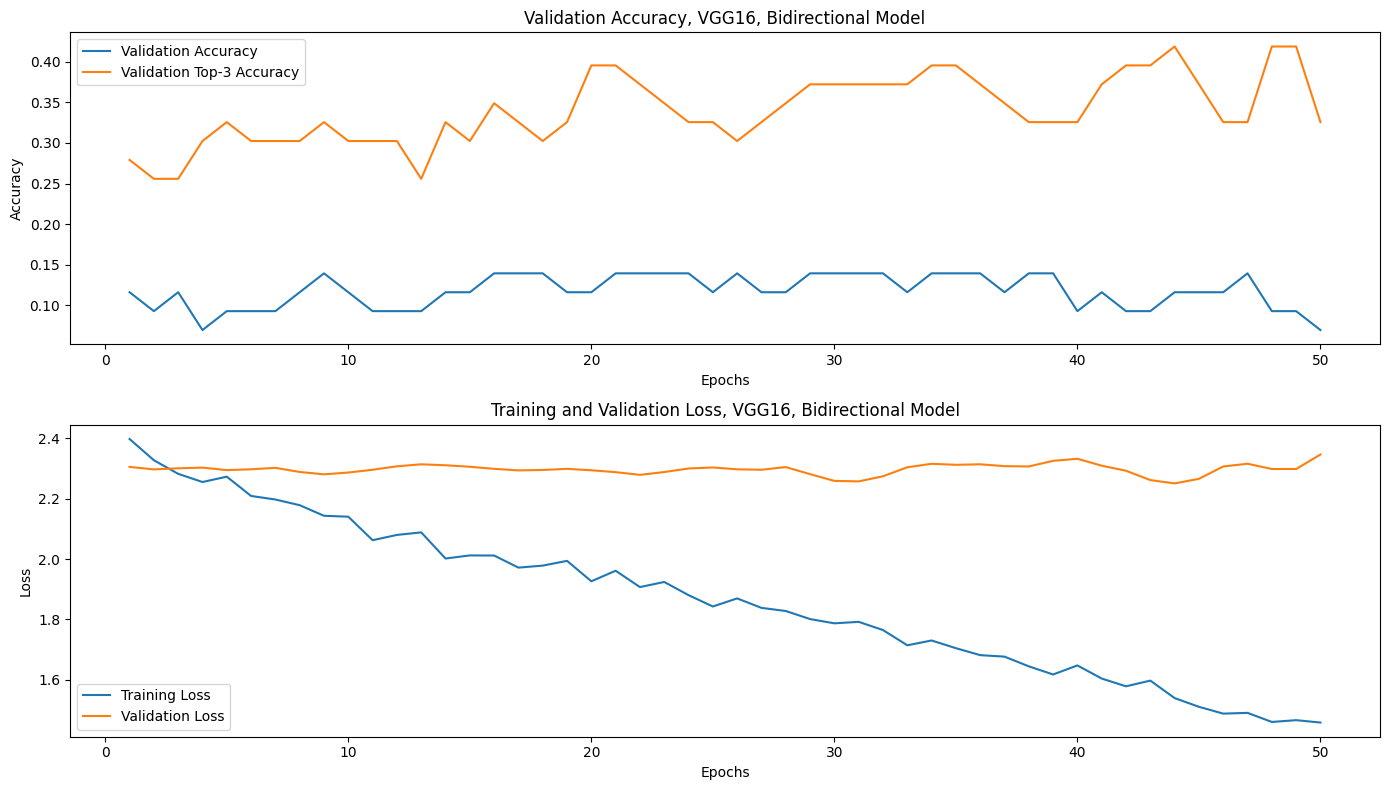

Max Top-3 Categorical Accuracy reached: 41.860464215278625
Max Sparse Categorical Accuracy reached: 13.953489065170288


In [ ]:
plot_metrics(history_VG_bd, "VGG16", "Bidirectional")

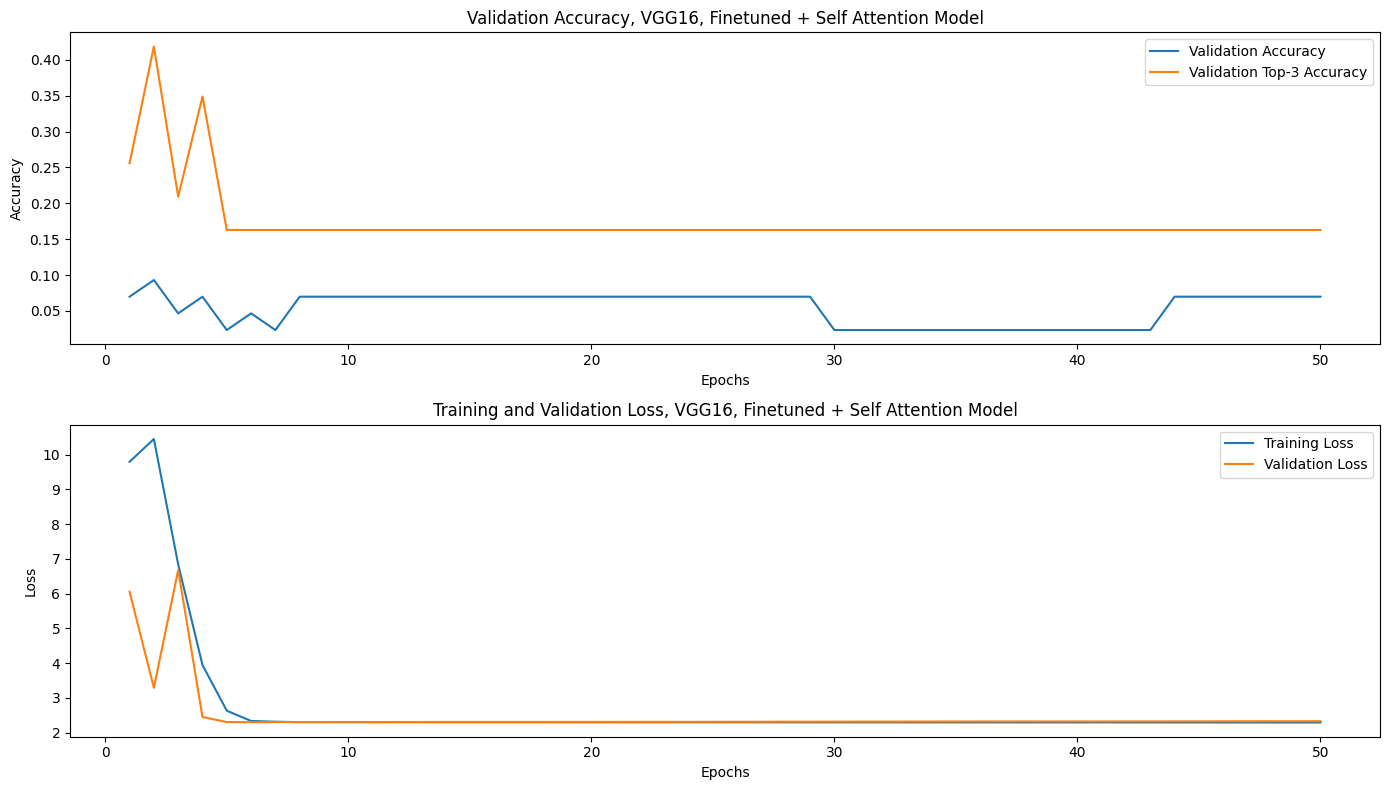

Max Top-3 Categorical Accuracy reached: 41.860464215278625
Max Sparse Categorical Accuracy reached: 9.302325546741486


In [ ]:
plot_metrics(history_VG_fine, "VGG16", "Finetuned + Self Attention")

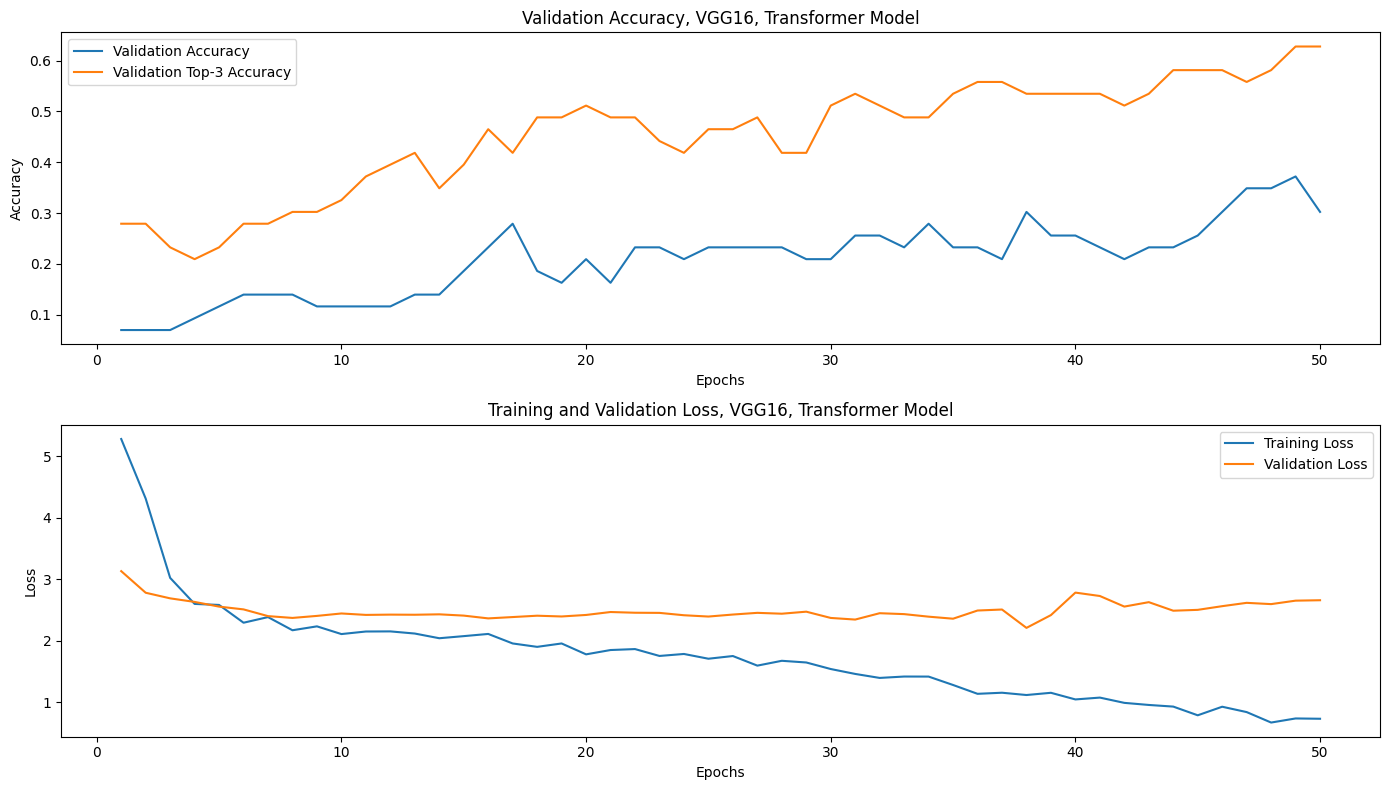

Max Top-3 Categorical Accuracy reached: 62.79069781303406
Max Sparse Categorical Accuracy reached: 37.20930218696594


In [ ]:
plot_metrics(history_VG_trans, "VGG16", "Transformer")

## **InceptionResNetV2**

### **GRUs Model**

In [ ]:
NUM_FEATURES_IR = 1536
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IR))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=
         [keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None),
          keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy", dtype=None)
          ])
    return rnn_model


# Utility for running experiments.
def run_experiment():

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data_IR[0], train_data_IR[1]],
        train_labels_IR,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_crossentropy = seq_model.evaluate([test_data_IR[0], test_data_IR[1]], test_labels_IR)
    print(f"Test accuracy: {round(accuracy*100, 2)}%")
    print(f"Test Top 5 Categorical Cross Entropy: {round(top_crossentropy*100, 2)}%")
    return history, seq_model


history_IR_seq, IR_sequence_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 9s 761ms/step - loss: 2.3548 - sparse_categorical_accuracy: 0.0918 - sparse_top_k_categorical_accuracy: 0.2653 - val_loss: 2.3213 - val_sparse_categorical_accuracy: 0.0233 - val_sparse_top_k_categorical_accuracy: 0.2326
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 2.3819 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.2755 - val_loss: 2.3288 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.2558
Epoch 3/50
4/4 [==============================] - 0s 34ms/step - loss: 2.3225 - sparse_categorical_accuracy: 0.1020 - sparse_top_k_categorical_accuracy: 0.2959 - val_loss: 2.3379 - val_sparse_categorical_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.2558
Epoch 4/50
4/4 [==============================] - 0s 34ms/step - loss: 2.2956 - sparse_categorical_accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.3061 - val_loss: 2.3711 - val_sparse_

### **Bidirectional Model**

In [ ]:
def get_bidirectional_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IR))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True))(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.Bidirectional(keras.layers.GRU(8))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    bd_model = get_bidirectional_model()
    history = bd_model.fit(
        [train_data_IR[0], train_data_IR[1]],
        train_labels_IR,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = bd_model.evaluate([test_data_IR[0], test_data_IR[1]], test_labels_IR)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, bd_model

# Run the experiment
history_IR_bd, IR_model = run_experiment()

Epoch 1/50
4/4 [==============================] - 18s 1s/step - loss: 2.4035 - sparse_categorical_accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.3265 - val_loss: 2.3519 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 2/50
4/4 [==============================] - 0s 50ms/step - loss: 2.3677 - sparse_categorical_accuracy: 0.0816 - sparse_top_k_categorical_accuracy: 0.3776 - val_loss: 2.3594 - val_sparse_categorical_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.2326
Epoch 3/50
4/4 [==============================] - 0s 45ms/step - loss: 2.4073 - sparse_categorical_accuracy: 0.0816 - sparse_top_k_categorical_accuracy: 0.3776 - val_loss: 2.3704 - val_sparse_categorical_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.2558
Epoch 4/50
4/4 [==============================] - 0s 47ms/step - loss: 2.3492 - sparse_categorical_accuracy: 0.0918 - sparse_top_k_categorical_accuracy: 0.3061 - val_loss: 2.3298 - val_spars

### **Self Attention Model**

In [ ]:
def get_fine_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES_IR))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Convolutional Layers
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(frame_features_input)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    # MultiHead Attention
    x = keras.layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.5)(x, x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Flatten()(x)

    # MLP
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation='relu')(x)

    # Output Layer
    output = keras.layers.Dense(len(class_vocab), activation='softmax')(x)


    rnn_model = keras.Model([frame_features_input, mask_input], output)
    optimizer = keras.optimizers.AdamW(learning_rate=1e-3, clipnorm=1.5)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    fine_model = get_fine_model()
    history = fine_model.fit(
        [train_data_IR[0], train_data_IR[1]],
        train_labels_IR,
        validation_split=0.3,
        epochs=EPOCHS,
    )
    _, accuracy, top_k_accuracy = fine_model.evaluate([test_data_IR[0], test_data_IR[1]], test_labels_IR)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, fine_model

# Run the experiment
history_IR_fine, fine_model = run_experiment()


Epoch 1/50
4/4 [==============================] - 18s 3s/step - loss: 12.3585 - accuracy: 0.0408 - sparse_top_k_categorical_accuracy: 0.2857 - val_loss: 4.9078 - val_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 2/50
4/4 [==============================] - 6s 1s/step - loss: 9.4382 - accuracy: 0.0918 - sparse_top_k_categorical_accuracy: 0.2551 - val_loss: 4.0765 - val_accuracy: 0.0233 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: 3.4890 - accuracy: 0.1122 - sparse_top_k_categorical_accuracy: 0.3469 - val_loss: 2.4468 - val_accuracy: 0.1628 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 3.3917 - accuracy: 0.0816 - sparse_top_k_categorical_accuracy: 0.2551 - val_loss: 2.5237 - val_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.3256
Epoch 5/50
4/4 [==============================] - 6s 2s/step - loss: 2.7904 - accu

### **Transformer Model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)


    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)
    return keras.Model([inputs, mask_input], outputs)

# Build and compile the model
def get_transformer_model():
    input_shape = (MAX_SEQ_LENGTH, NUM_FEATURES_IR)
    transformer_model = build_transformer_model(
        input_shape,
        head_size=256,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[64], # 64 IS BEST SO FAR
        dropout=0.5,
        mlp_dropout=0.5
    )
    optimizer = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)
    transformer_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=[
            "accuracy",
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="sparse_top_k_categorical_accuracy")
        ]
    )
    return transformer_model

def run_experiment():
    transformer_model = get_transformer_model()
    history = transformer_model.fit(
        [train_data_IR[0], train_data_IR[1]],
        train_labels_IR,
        validation_split=0.3,
        epochs=15,  # Adjusted for demonstration purposes
        batch_size=32
    )

    _, accuracy, top_k_accuracy = transformer_model.evaluate([test_data_IR[0], test_data_IR[1]], test_labels_IR)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 3 Categorical Accuracy: {round(top_k_accuracy * 100, 2)}%")
    return history, transformer_model
# Assuming train_data, train_labels, test_data, and test_labels are already prepared
history_IR_trans, trans_model = run_experiment()

Epoch 1/15
4/4 [==============================] - 15s 309ms/step - loss: 2.6588 - accuracy: 0.0918 - sparse_top_k_categorical_accuracy: 0.2959 - val_loss: 2.4350 - val_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.3023
Epoch 2/15
4/4 [==============================] - 0s 69ms/step - loss: 2.2672 - accuracy: 0.1531 - sparse_top_k_categorical_accuracy: 0.4184 - val_loss: 2.3264 - val_accuracy: 0.0698 - val_sparse_top_k_categorical_accuracy: 0.3721
Epoch 3/15
4/4 [==============================] - 0s 69ms/step - loss: 2.2503 - accuracy: 0.1531 - sparse_top_k_categorical_accuracy: 0.3776 - val_loss: 2.3977 - val_accuracy: 0.0465 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 4/15
4/4 [==============================] - 0s 70ms/step - loss: 2.2381 - accuracy: 0.2245 - sparse_top_k_categorical_accuracy: 0.4286 - val_loss: 2.4259 - val_accuracy: 0.0930 - val_sparse_top_k_categorical_accuracy: 0.2791
Epoch 5/15
4/4 [==============================] - 0s 69ms/step - loss: 2.0

### **Visualization of Results**

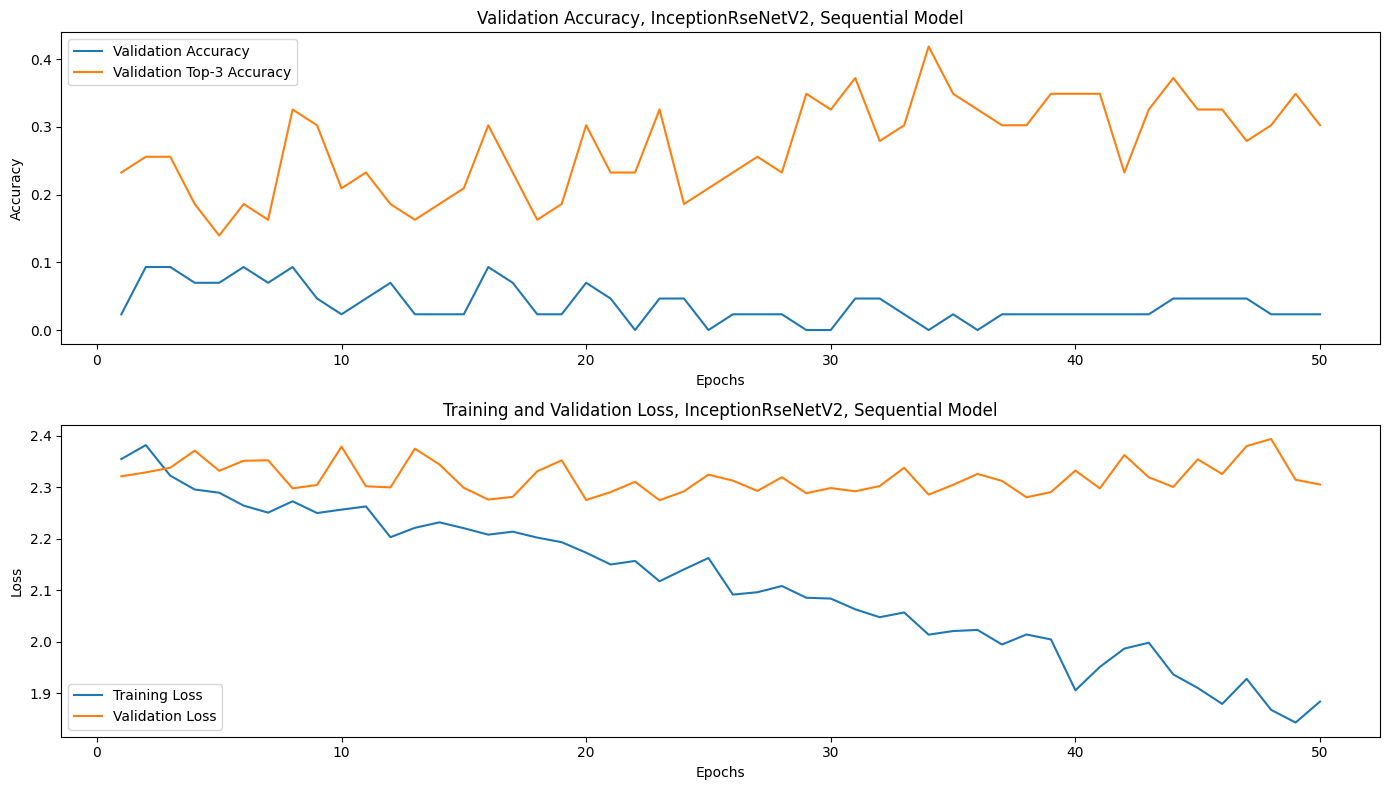

Max Top-3 Categorical Accuracy reached: 41.860464215278625
Max Sparse Categorical Accuracy reached: 9.302325546741486


In [ ]:
plot_metrics(history_IR_seq, "InceptionRseNetV2", "Sequential")

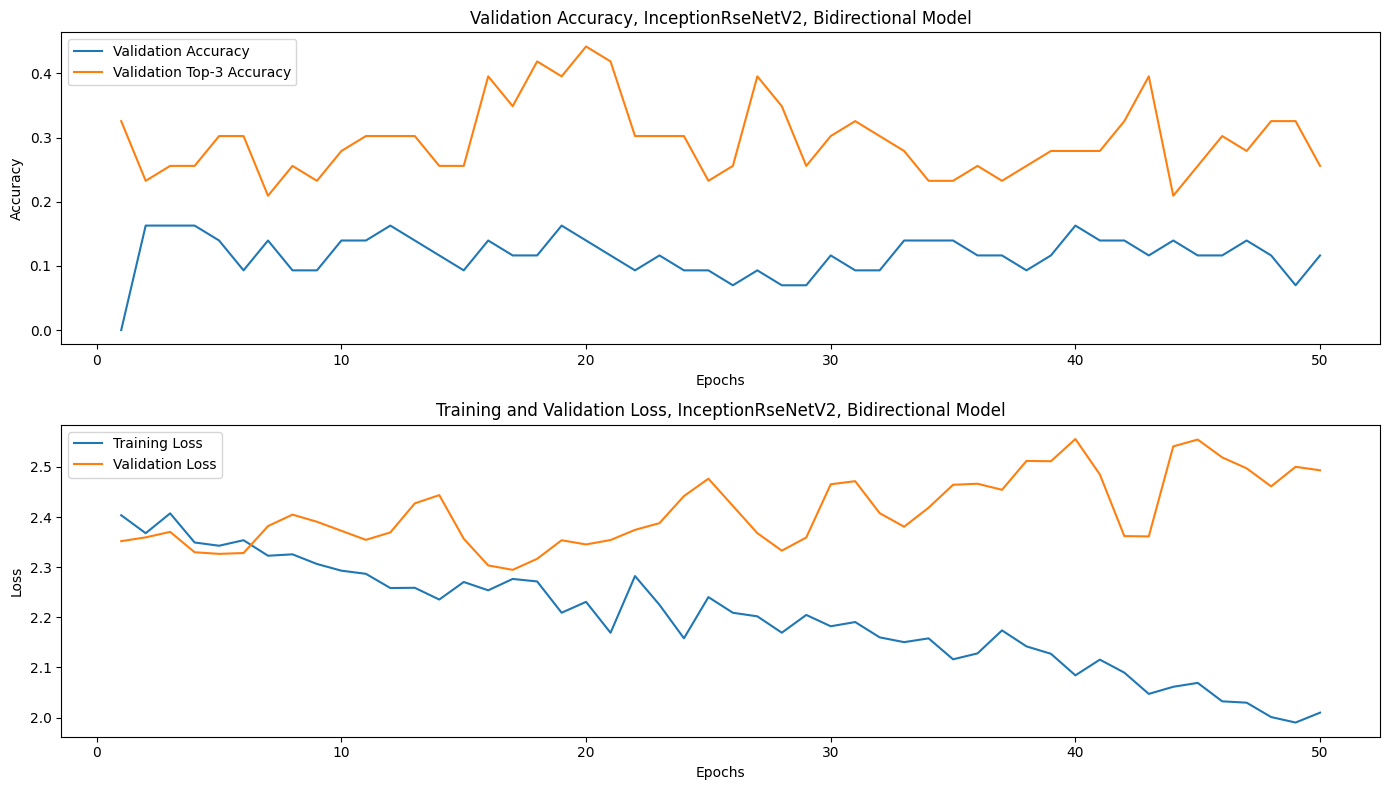

Max Top-3 Categorical Accuracy reached: 44.186046719551086
Max Sparse Categorical Accuracy reached: 16.27907007932663


In [ ]:
plot_metrics(history_IR_bd, "InceptionRseNetV2", "Bidirectional")

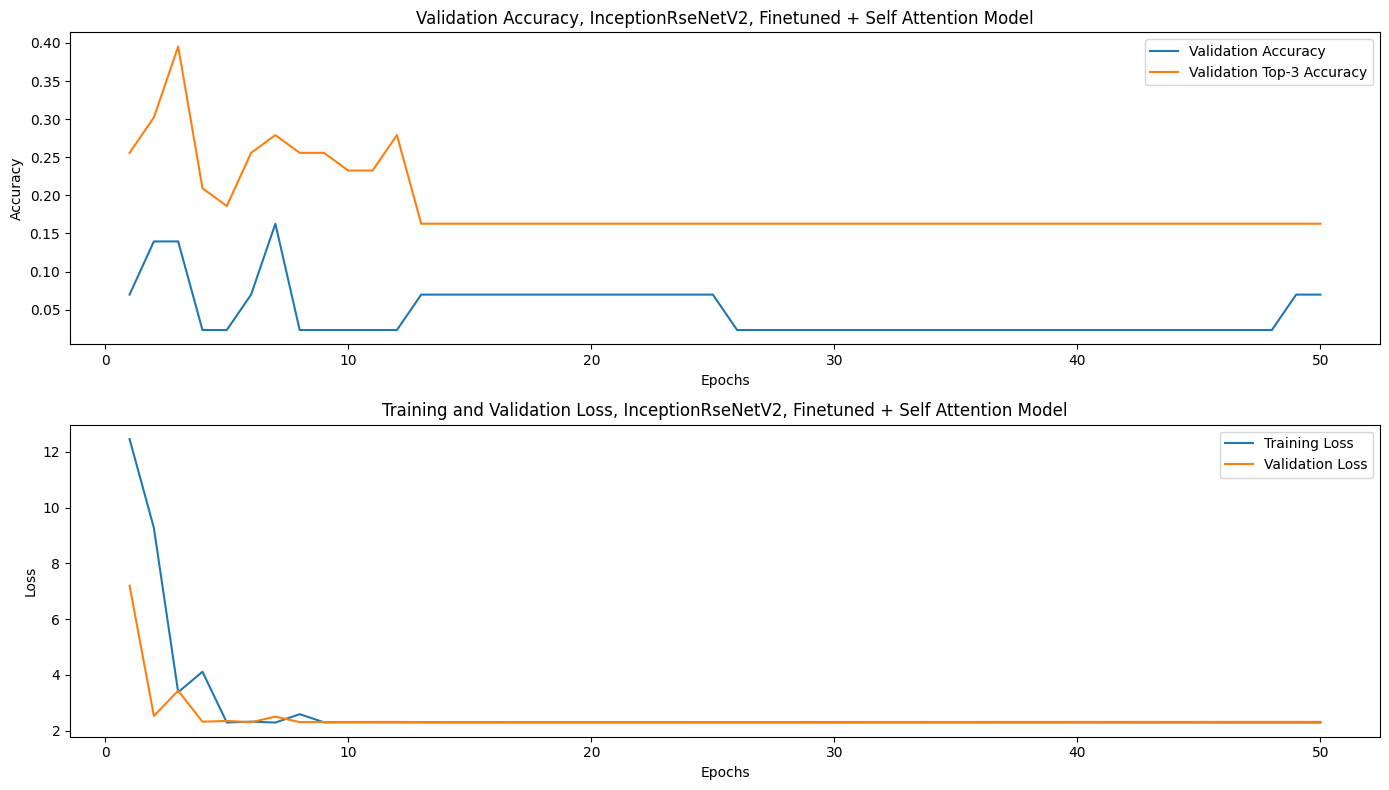

Max Top-3 Categorical Accuracy reached: 39.5348846912384
Max Sparse Categorical Accuracy reached: 16.27907007932663


In [ ]:
plot_metrics(history_IR_fine, "InceptionRseNetV2", "Finetuned + Self Attention")

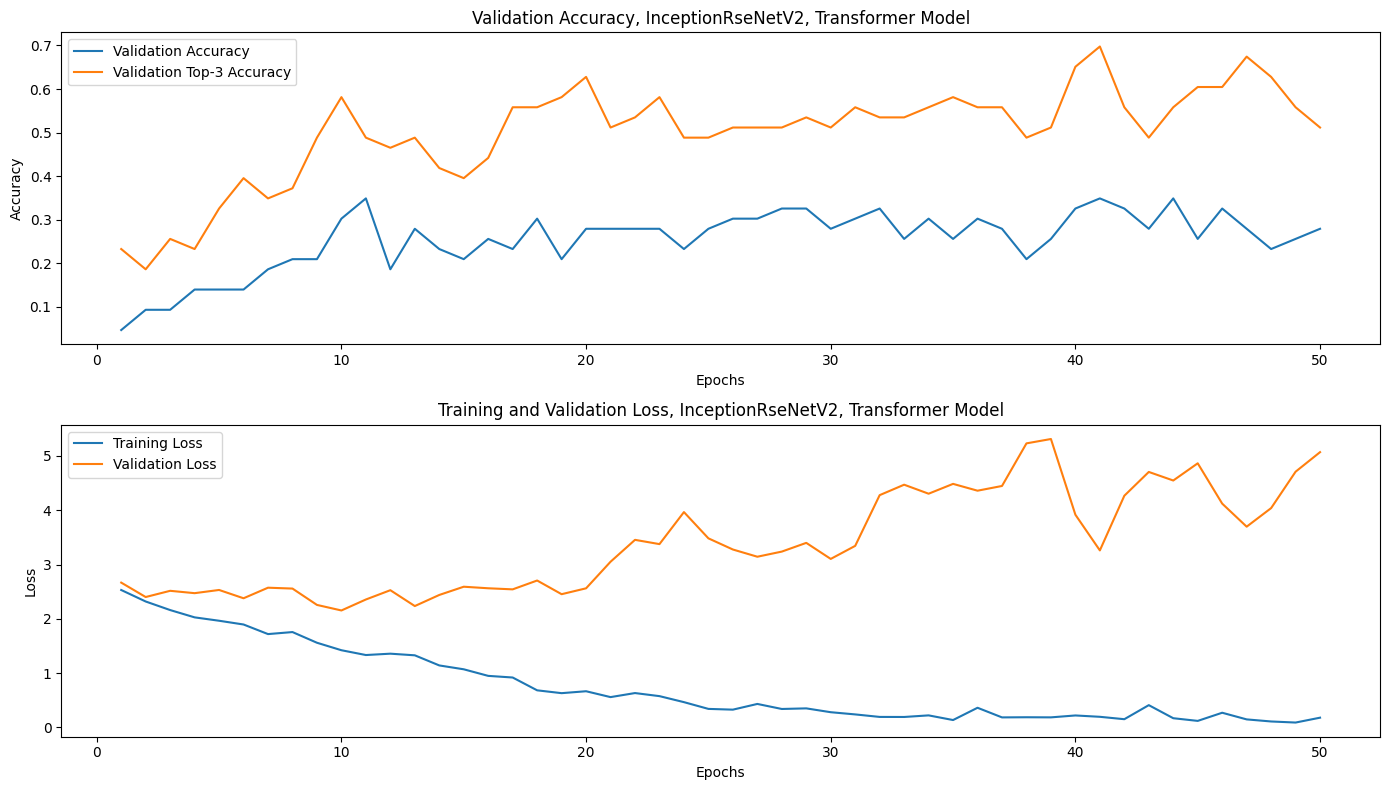

Max Top-3 Categorical Accuracy reached: 69.76743936538696
Max Sparse Categorical Accuracy reached: 34.88371968269348


In [ ]:
plot_metrics(history_IR_trans, "InceptionRseNetV2", "Transformer")

In [ ]:
# For data preprocessing
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

# For Data Augmentation

# Horizontal flip: it reverses the intensity of pixels
def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

# Speed up: skipping certain pixels in the color channel to reduce detail in the image
def speedup(data):
    return data[::2]

# Rotation: it rotates {90,180,270}
def rotate(data):
    data_copy = data.copy()
    a = np.random.randint(1,4)
    return np.rot90(data_copy, k=a)

# Apply data augmentation
def apply_aug(data,counter):
  aug_functions = [hflip, speedup,rotate]
  return aug_functions[counter](data)

In [ ]:
# Take a dataframe in which it is saved the path and the label for each video
labels_original = pd.read_csv("/kaggle/input/wlasl-processed/videos.csv")
del labels_original['Unnamed: 0']
del labels_original['url']
labels_original.set_index('image_id',inplace = True)
labels_original

gloss train_test video_name_folder
image_id                                      
69241        book      train         69241.mp4
65225        book      train         65225.mp4
68011        book      train         68011.mp4
68208        book      train         68208.mp4
68012        book      train         68012.mp4
...           ...        ...               ...
63186     whistle      train         63186.mp4
63187     whistle      train         63187.mp4
63188     whistle      train         63188.mp4
63189     whistle      train         63189.mp4
63190     whistle      train         63190.mp4

[21083 rows x 3 columns]

In [ ]:
# Take 20 most expressed labels
labels= pd.concat([labels_original[labels_original['gloss'] == i] for i in labels_original['gloss'].value_counts()[:20].index ])
del labels['train_test']
labels

gloss video_name_folder
image_id                        
69241     book         69241.mp4
65225     book         65225.mp4
68011     book         68011.mp4
68208     book         68208.mp4
68012     book         68012.mp4
...        ...               ...
13196     cool         13196.mp4
13206     cool         13206.mp4
13207     cool         13207.mp4
13208     cool         13208.mp4
13209     cool         13209.mp4

[499 rows x 2 columns]

In [ ]:
# Extract frames into videos and append it into a 3X3 grid
video_path = "/kaggle/input/wlasl-processed/videos"
folder_square = "/kaggle/input/dta/vid"

def create_dataset_mid(video_path,folder_path,n_frames, method = "square"):

  # If not true create the folder
  os.makedirs(folder_path, exist_ok=True)
  # Create a copy of labels
  a = labels.copy()
  for filename in a['video_name_folder']:
      # Take the path
      path = os.path.join(video_path,filename)
      # Put it into a video format
      clip = VideoFileClip(path)
      # Compute total number of frames
      total_frames = int(clip.fps * clip.duration)
      # Initialize an empty list to store frames
      all_frames = []
      # Iterate through each frame index and extract the frame
      for idx in range(total_frames):
          frame = clip.get_frame(idx / clip.fps)
          all_frames.append(frame)

      if len(all_frames) > n_frames:
        mid = len(all_frames)//2
        if n_frames % 2 != 0:
          beg = mid - n_frames//2
          end = mid + n_frames//2 + 1
        else:
          beg = mid - n_frames//2
          end = mid + n_frames//2
        selected_frames = all_frames[beg:end]


      elif len(all_frames) < n_frames:
        selected_frames = all_frames
        while len(selected_frames) < n_frames:
          a = random.choice(selected_frames)
          for j in range(len(selected_frames)):
            if np.all(a == selected_frames[j]):
              selected_frames.insert(j,a)
              break
      else:
        selected_frames = all_frames

      if method == "square": #here we assume the number is a perfect square
        # Create canvas dimensions
        canvas_width = int(np.sqrt(n_frames)) * all_frames[0].shape[1]
        canvas_height = int(np.sqrt(n_frames)) * all_frames[0].shape[0]
        # Create a blank canvas
        canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
        # Place frames on the canvas
        for i, frame in enumerate(selected_frames):
            row = i // int(np.sqrt(n_frames))
            col = i % int(np.sqrt(n_frames))
            canvas[row * frame.shape[0]: (row + 1) * frame.shape[0],
                  col * frame.shape[1]: (col + 1) * frame.shape[1]] = frame

        ## Data Augmentation
        for d in range(3):
          augmented = apply_aug(canvas.astype('float64').copy(),d)
          augmented = normalize(to_grayscale(augmented.astype('float64')))
          augmented = np.expand_dims(augmented,axis = 0)
          augmented = torch.from_numpy(augmented).to(torch.float32)
          augmented = torch.nn.functional.interpolate(augmented.unsqueeze(0), size=(768,768), mode='bilinear', align_corners=False)
          augmented = augmented.squeeze(0).squeeze(0)
          augmented = augmented.numpy().astype('float64')
          augmented = normalize(to_grayscale(augmented))
          output_path_aug =os.path.join(folder_path, f"{filename[:-4]}_aug_{d}.jpg")
          cv2.imwrite(output_path_aug, augmented)
          aug_dict = {'gloss':labels['gloss'][int(filename[:-4])], 'video_name_folder':output_path_aug}
          # We update the labels
          labels.loc[f"{filename[:-4]}_aug_{d}"] = aug_dict

        # Add canvas to the folder
        canvas = normalize(to_grayscale(canvas.astype('float64')))
        output_path_canvas = os.path.join(folder_path, f"{filename[:-4]}.jpg")
        cv2.imwrite(output_path_canvas, canvas)
        # We update the labels
        labels['video_name_folder'][int(filename[:-4])] = output_path_canvas

  print("Frames extracted and saved successfully!")

In [ ]:
create_dataset_mid(video_path,folder_square,9)

Frames extracted and saved successfully!


In [ ]:
# Encode each label with an integer number
label_mapping = {i : counter for counter,i in enumerate(labels['gloss'].value_counts()[:20].index)}
labels['gloss'] = labels['gloss'].map(label_mapping)
labels

gloss                                  video_name_folder
image_id                                                             
69241            0  /content/drive/MyDrive/Machine Learning Projec...
65225            0  /content/drive/MyDrive/Machine Learning Projec...
68011            0  /content/drive/MyDrive/Machine Learning Projec...
68208            0  /content/drive/MyDrive/Machine Learning Projec...
68012            0  /content/drive/MyDrive/Machine Learning Projec...
...            ...                                                ...
13208_aug_1     19  /content/drive/MyDrive/Machine Learning Projec...
13208_aug_2     19  /content/drive/MyDrive/Machine Learning Projec...
13209_aug_0     19  /content/drive/MyDrive/Machine Learning Projec...
13209_aug_1     19  /content/drive/MyDrive/Machine Learning Projec...
13209_aug_2     19  /content/drive/MyDrive/Machine Learning Projec...

[1996 rows x 2 columns]

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, lab_pd,image_folder,transform = None):
    self.data = lab_pd
    self.image_folder = image_folder
    self.transform = transform
  def __len__(self):
    return len(self.data)
  def shape(self):
    return self.data.shape
  def __getitem__(self,index):
    actual_index = self.data.index[index]
    image_path = self.data['video_name_folder'][actual_index]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.reshape((1,768,768))
    image = torch.from_numpy(image).to(torch.float32)
    if self.transform:
      image = self.transform(image)
    label = self.data['gloss'][actual_index]
    return image, torch.tensor(label)

dataset = CustomDataset(lab_pd = labels, image_folder='/kaggle/input/dta/vid',
                        transform=Resize((256,256))) # resize for reduce computational complexity

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders and divide into batches of 10
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
for X,y in train_loader:
    print(f"Shape of X [b, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y {y.shape} {y.dtype}")
    break


Shape of X [b, C, H, W]: torch.Size([10, 1, 256, 256]) torch.float32
Shape of y torch.Size([10]) torch.int64


## **Models**

In [ ]:
class CNN(nn.Module):
    def __init__(self):

        super().__init__()

        self.net = nn.Sequential(

            nn.Conv2d(in_channels= 1, out_channels = 512, kernel_size = 35, stride = 3), # 512X75X75
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(3),# out 512X25X25



            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 5, stride = 2), # out 1024X10X10
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AvgPool2d(10), # out 512X1X1

            nn.Flatten(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),


            nn.Dropout(0.5),

            nn.Linear(512, 20)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(65536,3000),
        nn.BatchNorm1d(3000),
        nn.ReLU(),
        nn.Linear(3000,1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 20)
    )
  def forward(self, x):
    logits = self.net(x)
    return logits

## **Training Testing and Metrics**

In [ ]:
model = MLP().to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
f1_scores = []
roc_auc_scores = []
precision_scores = []
recall_scores = []
def train(dataloader, model, loss_fn, optimizer,train_loss_for_graph,acc_train):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0.0
    correct = 0
    loss_for_graph = []
    for X, y in dataloader:
      X, y = X.to('cuda'), y.to('cuda')

      # Prediction and loss computation
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backward pass.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Statistics
      train_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute and print some data to monitor the training
    train_loss /= num_batches
    train_loss_for_graph.append(train_loss)
    correct /= size
    acc_train.append(correct)
    print(f"TRAINING - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {loss:>7f}")


def test(dataloader, model, loss_fn,test_loss_for_graph,acc_test):

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0.0, 0
  # We have to infer so no gradient
  y_true = []
  y_pred = []
  y_prob = []
  with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        # Some Statistics for performance
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Additional statistics
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_prob.extend(torch.nn.functional.softmax(pred, dim=1).cpu().numpy())

  test_loss /= num_batches
  test_loss_for_graph.append(test_loss)
  correct /= size
  acc_test.append(correct)
  # All the metrics
  f1 = f1_score(y_true, y_pred, average='weighted')
  roc_auc = roc_auc_score(y_true, y_prob, average='weighted', multi_class='ovo')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  # Save metrics
  f1_scores.append(f1)
  roc_auc_scores.append(roc_auc)
  precision_scores.append(precision)
  recall_scores.append(recall)

  print(f"TESTING  - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {test_loss:>8f}\n")

epoch = 100
# Let us save the statistics
epochs = []
train_loss_for_graph = []
acc_train = []
test_loss_for_graph = []
acc_test = []

for t in range(epoch):
    print(f"Epoch {t+1}\n------------------")
    train(train_loader, model, loss_fn, optimizer,train_loss_for_graph,acc_train)
    test(test_loader, model, loss_fn,test_loss_for_graph,acc_test)
    epochs.append(t)
print("Done!")

metrics_add_df = pd.DataFrame({
    'F1_Score': f1_scores,
    'ROC_AUC_Score': roc_auc_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'Accuracy Train': acc_train,
    'Accuracy Test': acc_test,
    'Train Loss': train_loss_for_graph,
    'Test Loss': test_loss_for_graph

})


Epoch 1
------------------
TRAINING - Accuracy:   7.5%, Avg loss: 3.386236


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  10.0%, Avg loss: 2.952178

Epoch 2
------------------
TRAINING - Accuracy:   9.4%, Avg loss: 3.685433


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:   9.2%, Avg loss: 2.949713

Epoch 3
------------------
TRAINING - Accuracy:  10.8%, Avg loss: 2.851827


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  12.8%, Avg loss: 2.870404

Epoch 4
------------------
TRAINING - Accuracy:  11.8%, Avg loss: 2.860969


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  13.2%, Avg loss: 2.805900

Epoch 5
------------------
TRAINING - Accuracy:  13.2%, Avg loss: 3.311047


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  14.8%, Avg loss: 2.803716

Epoch 6
------------------
TRAINING - Accuracy:  15.2%, Avg loss: 2.555582


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  19.5%, Avg loss: 2.694098

Epoch 7
------------------
TRAINING - Accuracy:  16.4%, Avg loss: 2.465868


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  16.8%, Avg loss: 2.696354

Epoch 8
------------------
TRAINING - Accuracy:  19.0%, Avg loss: 2.674918


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  22.5%, Avg loss: 2.615906

Epoch 9
------------------
TRAINING - Accuracy:  21.4%, Avg loss: 3.466529


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  20.2%, Avg loss: 2.675528

Epoch 10
------------------
TRAINING - Accuracy:  21.6%, Avg loss: 2.535376
TESTING  - Accuracy:  23.2%, Avg loss: 2.542432

Epoch 11
------------------
TRAINING - Accuracy:  23.8%, Avg loss: 2.565006


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  20.0%, Avg loss: 2.667686

Epoch 12
------------------
TRAINING - Accuracy:  26.4%, Avg loss: 3.714745
TESTING  - Accuracy:  24.5%, Avg loss: 2.457941

Epoch 13
------------------
TRAINING - Accuracy:  27.6%, Avg loss: 2.815291


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  21.5%, Avg loss: 2.613199

Epoch 14
------------------
TRAINING - Accuracy:  30.4%, Avg loss: 1.752277
TESTING  - Accuracy:  31.2%, Avg loss: 2.245775

Epoch 15
------------------
TRAINING - Accuracy:  31.8%, Avg loss: 2.414228
TESTING  - Accuracy:  25.8%, Avg loss: 2.456652

Epoch 16
------------------
TRAINING - Accuracy:  35.7%, Avg loss: 2.904823
TESTING  - Accuracy:  26.2%, Avg loss: 2.642790

Epoch 17
------------------
TRAINING - Accuracy:  36.9%, Avg loss: 1.405232
TESTING  - Accuracy:  30.0%, Avg loss: 2.359511

Epoch 18
------------------
TRAINING - Accuracy:  39.5%, Avg loss: 1.960329


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  28.7%, Avg loss: 2.481839

Epoch 19
------------------
TRAINING - Accuracy:  40.5%, Avg loss: 2.372599
TESTING  - Accuracy:  37.0%, Avg loss: 2.144489

Epoch 20
------------------
TRAINING - Accuracy:  40.9%, Avg loss: 1.352074
TESTING  - Accuracy:  28.2%, Avg loss: 2.506646

Epoch 21
------------------
TRAINING - Accuracy:  43.7%, Avg loss: 1.948036


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  33.8%, Avg loss: 2.315494

Epoch 22
------------------
TRAINING - Accuracy:  45.7%, Avg loss: 1.086303
TESTING  - Accuracy:  36.2%, Avg loss: 2.171167

Epoch 23
------------------
TRAINING - Accuracy:  48.7%, Avg loss: 2.676487
TESTING  - Accuracy:  38.5%, Avg loss: 2.114676

Epoch 24
------------------
TRAINING - Accuracy:  51.1%, Avg loss: 1.901897
TESTING  - Accuracy:  44.8%, Avg loss: 1.999977

Epoch 25
------------------
TRAINING - Accuracy:  50.8%, Avg loss: 1.231930
TESTING  - Accuracy:  39.5%, Avg loss: 2.122211

Epoch 26
------------------
TRAINING - Accuracy:  51.5%, Avg loss: 0.932669
TESTING  - Accuracy:  42.8%, Avg loss: 2.041479

Epoch 27
------------------
TRAINING - Accuracy:  54.8%, Avg loss: 0.980373
TESTING  - Accuracy:  45.0%, Avg loss: 1.970549

Epoch 28
------------------
TRAINING - Accuracy:  57.5%, Avg loss: 1.697849
TESTING  - Accuracy:  49.5%, Avg loss: 1.787663

Epoch 29
------------------
TRAINING - Accuracy:  55.7%, Avg loss: 2.476713


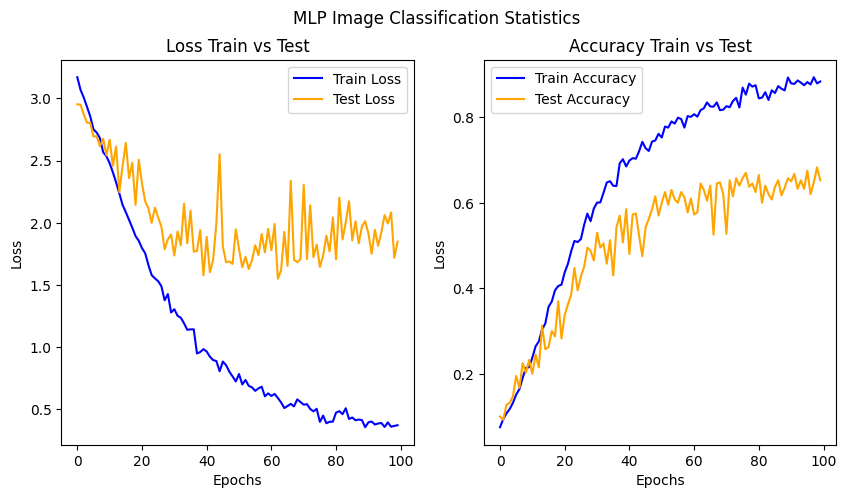

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('MLP Image Classification Statistics')
axs[0].plot(epochs, train_loss_for_graph, label = "Train Loss",color='blue')
axs[0].set_title('Loss Train vs Test')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].plot(epochs, test_loss_for_graph, label = "Test Loss",color='orange')
axs[0].legend()

axs[1].plot(epochs, acc_train, label = "Train Accuracy",color='blue')
axs[1].set_title('Accuracy Train vs Test')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].plot(epochs, acc_test, label = "Test Accuracy",color='orange')
axs[1].legend()
plt.savefig("MLP_BEST.png")
plt.show()


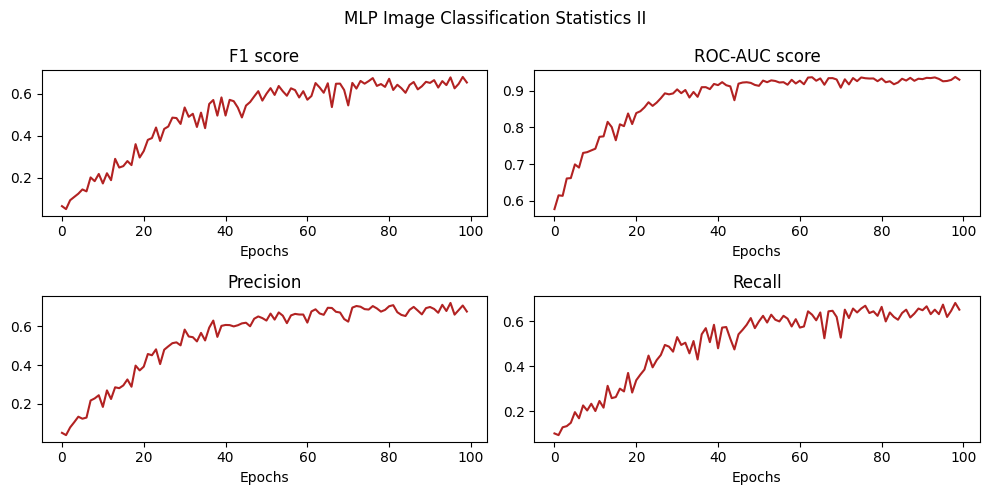

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('MLP Image Classification Statistics II')
axs[0][0].plot(epochs, f1_scores, color='firebrick')
axs[0][0].set_title('F1 score')
axs[0][0].set_xlabel('Epochs')

axs[0][1].plot(epochs, roc_auc_scores,color='firebrick')
axs[0][1].set_title("ROC-AUC score")
axs[0][1].set_xlabel('Epochs')

axs[1][0].plot(epochs, precision_scores, color='firebrick')
axs[1][0].set_title('Precision')
axs[1][0].set_xlabel('Epochs')

axs[1][1].plot(epochs, recall_scores, color='firebrick')
axs[1][1].set_title('Recall')
axs[1][1].set_xlabel('Epochs')

plt.savefig("metrics_MLP.png")
plt.tight_layout()
plt.show()

In [ ]:
model = CNN().to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

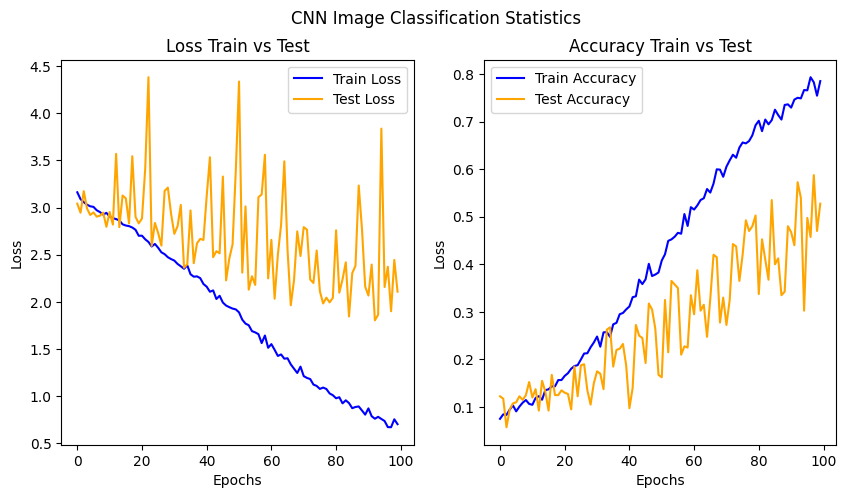

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('CNN Image Classification Statistics')
axs[0].plot(epochs, train_loss_for_graph, label = "Train Loss",color='blue')
axs[0].set_title('Loss Train vs Test')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].plot(epochs, test_loss_for_graph, label = "Test Loss",color='orange')
axs[0].legend()

axs[1].plot(epochs, acc_train, label = "Train Accuracy",color='blue')
axs[1].set_title('Accuracy Train vs Test')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].plot(epochs, acc_test, label = "Test Accuracy",color='orange')
axs[1].legend()
plt.savefig("CNN_BEST.png")
plt.show()

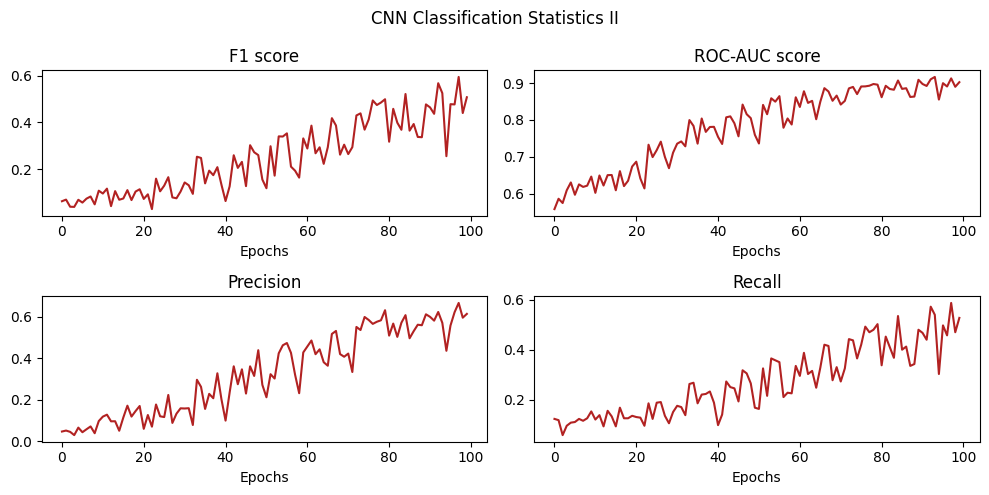

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('CNN Classification Statistics II')
axs[0][0].plot(epochs, f1_scores, color='firebrick')
axs[0][0].set_title('F1 score')
axs[0][0].set_xlabel('Epochs')

axs[0][1].plot(epochs, roc_auc_scores,color='firebrick')
axs[0][1].set_title("ROC-AUC score")
axs[0][1].set_xlabel('Epochs')

axs[1][0].plot(epochs, precision_scores, color='firebrick')
axs[1][0].set_title('Precision')
axs[1][0].set_xlabel('Epochs')

axs[1][1].plot(epochs, recall_scores, color='firebrick')
axs[1][1].set_title('Recall')
axs[1][1].set_xlabel('Epochs')

plt.savefig("metrics_CNN_crazy.png")
plt.tight_layout()
plt.show()

### **Dataset Creation**

In [ ]:
# Take a dataframe in which it is saved the path and the label for each video
labels_original = pd.read_csv("/content/drive/MyDrive/Machine Learning Projec/Datasets/labeled_dataset_21000_videos.csv")
del labels_original['Unnamed: 0']
del labels_original['url']
labels_original.set_index('image_id',inplace = True)
labels_original

gloss train_test video_name_folder
image_id                                      
69241        book      train         69241.mp4
65225        book      train         65225.mp4
68011        book      train         68011.mp4
68208        book      train         68208.mp4
68012        book      train         68012.mp4
...           ...        ...               ...
63186     whistle      train         63186.mp4
63187     whistle      train         63187.mp4
63188     whistle      train         63188.mp4
63189     whistle      train         63189.mp4
63190     whistle      train         63190.mp4

[21083 rows x 3 columns]

In [ ]:
# Take 20 most expressed labels
labels= pd.concat([labels_original[labels_original['gloss'] == i] for i in labels_original['gloss'].value_counts()[:20].index ])
del labels['train_test']
labels

gloss video_name_folder
image_id                        
69241     book         69241.mp4
65225     book         65225.mp4
68011     book         68011.mp4
68208     book         68208.mp4
68012     book         68012.mp4
...        ...               ...
62988     what         62988.mp4
62975     what         62975.mp4
62965     what         62965.mp4
62979     what         62979.mp4
62966     what         62966.mp4

[499 rows x 2 columns]

In [ ]:
dataset = []
labels_list = []
n_frames = 9

for counter,ix in enumerate(labels.index):
  path = "/kaggle/input/wlasl-processed/videos" + labels['video_name_folder'][ix]
  clip = VideoFileClip(path)
  # Compute total number of frames
  total_frames = int(clip.fps * clip.duration)
  # Initialize an empty list to store frames
  all_frames = []
  # Iterate through each frame index and extract the frame
  for idx in range(total_frames):
      frame = clip.get_frame(idx / clip.fps)
      all_frames.append(frame)
  # Choose n frames
  if len(all_frames) > n_frames:
    mid = len(all_frames)//2
    if n_frames % 2 != 0:
      beg = mid - n_frames//2
      end = mid + n_frames//2 + 1
    else:
      beg = mid - n_frames//2
      end = mid + n_frames//2
    selected_frames = all_frames[beg:end]

  elif len(all_frames) < n_frames:
    selected_frames = all_frames
    while len(selected_frames) < n_frames:
      a = random.choice(selected_frames)
      for j in range(len(selected_frames)):
        if np.all(a == selected_frames[j]):
          selected_frames.insert(j,a)
          break
  else:
    selected_frames = all_frames

  # Data augmentation of the frames
  for d in range(3):
    augmented_frames = selected_frames.copy()
    for counter,frame in enumerate(selected_frames):
        augmented = apply_aug(frame.astype('float64').copy(),d)
        augmented = normalize(to_grayscale(augmented.astype('float64')))
        augmented = np.expand_dims(augmented,axis = 0)
        augmented = torch.from_numpy(augmented).to(torch.float32)
        augmented = torch.nn.functional.interpolate(augmented.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False)
        augmented = augmented.squeeze(0)
        augmented = augmented.numpy().astype('float64')
        augmented = normalize(augmented)
        augmented_frames[counter] = augmented
    # Here I stack it into the last channel
    aug_image = np.stack(augmented_frames, axis=0)
    aug_image = np.squeeze(aug_image, axis=1)
    dataset.append(aug_image)
    labels_list.append(labels['gloss'][ix].item())
  # Normalize and grayscale all the frames
  for i in range(len(selected_frames)):
    selected_frames[i] = normalize(to_grayscale(selected_frames[i]))
  # Put them in the color channel
  image = np.stack(selected_frames, axis=0)
  dataset.append(image)
  labels_list.append(labels['gloss'][ix].item())



In [ ]:
# Convert numpy arrays to PyTorch tensors
images_tensor = torch.tensor(dataset, dtype=torch.float32)
labels_tensor = torch.tensor(labels_list, dtype=torch.int64)

# Combine images and labels into a single dataset
dataset = TensorDataset(images_tensor, labels_tensor)

train_dataset, test_dataset = train_test_split(dataset, test_size= 0.2, random_state=42)

# We keep batches of 10
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=10, shuffle=False)

In [ ]:
for X,y in train_loader:
    print(f"Shape of X [b, C, H, W]: {X.shape}")
    print(f"Shape of y {y.shape} {y.dtype}")
    break

Shape of X [b, C, H, W]: torch.Size([10, 9, 256, 256])
Shape of y torch.Size([10]) torch.int64


### **Model**

In [ ]:
class CNN_crazy(nn.Module):
    def __init__(self):

        super().__init__()

        self.net = nn.Sequential(

            nn.Conv2d(in_channels= 9, out_channels = 512, kernel_size = 12), # 512X245X245
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.AvgPool2d(5),# out 512X49X49



            nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 5), # out 1024X45X45
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.AvgPool2d(5), # out 1024X9X9

            nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 5), # out 1024X5X5
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.AvgPool2d(5),



            nn.Flatten(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),


            nn.Dropout(0.5),

            nn.Linear(512, 20)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

In [ ]:
model = CNN_crazy().to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
f1_scores = []
roc_auc_scores = []
precision_scores = []
recall_scores = []
def train(dataloader, model, loss_fn, optimizer,train_loss_for_graph,acc_train):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0.0
    correct = 0
    loss_for_graph = []
    for X, y in dataloader:
      X, y = X.to('cuda'), y.to('cuda')

      # Prediction and loss computation
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backward pass.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Statistics
      train_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute and print some data to monitor the training
    train_loss /= num_batches
    train_loss_for_graph.append(train_loss)
    correct /= size
    acc_train.append(correct)
    print(f"TRAINING - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {loss:>7f}")


def test(dataloader, model, loss_fn,test_loss_for_graph,acc_test):

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0.0, 0
  # We have to infer so no gradient
  y_true = []
  y_pred = []
  y_prob = []
  with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to('cuda'), y.to('cuda')
        pred = model(X)
        # Some Statistics for performance
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Additional statistics
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.argmax(1).cpu().numpy())
        y_prob.extend(torch.nn.functional.softmax(pred, dim=1).cpu().numpy())

  test_loss /= num_batches
  test_loss_for_graph.append(test_loss)
  correct /= size
  acc_test.append(correct)
  # All the metrics
  f1 = f1_score(y_true, y_pred, average='weighted')
  roc_auc = roc_auc_score(y_true, y_prob, average='weighted', multi_class='ovo')
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  # Save metrics
  f1_scores.append(f1)
  roc_auc_scores.append(roc_auc)
  precision_scores.append(precision)
  recall_scores.append(recall)

  print(f"TESTING  - Accuracy: {(100 * correct):>5.1f}%, Avg loss: {test_loss:>8f}\n")

epoch = 100
# Let us save the statistics
epochs = []
train_loss_for_graph = []
acc_train = []
test_loss_for_graph = []
acc_test = []

for t in range(epoch):
    print(f"Epoch {t+1}\n------------------")
    train(train_loader, model, loss_fn, optimizer,train_loss_for_graph,acc_train)
    test(test_loader, model, loss_fn,test_loss_for_graph,acc_test)
    epochs.append(t)
print("Done!")

metrics_add_df = pd.DataFrame({
    'F1_Score': f1_scores,
    'ROC_AUC_Score': roc_auc_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'Accuracy Train': acc_train,
    'Accuracy Test': acc_test,
    'Train Loss': train_loss_for_graph,
    'Test Loss': test_loss_for_graph

})


Epoch 1
------------------
TRAINING - Accuracy:   7.8%, Avg loss: 3.189950


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:   8.2%, Avg loss: 3.072058

Epoch 2
------------------
TRAINING - Accuracy:  10.0%, Avg loss: 3.470543


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  11.8%, Avg loss: 2.989245

Epoch 3
------------------
TRAINING - Accuracy:   8.8%, Avg loss: 2.517690


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  15.5%, Avg loss: 2.901802

Epoch 4
------------------
TRAINING - Accuracy:  10.1%, Avg loss: 3.199591


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  14.8%, Avg loss: 2.921138

Epoch 5
------------------
TRAINING - Accuracy:  11.8%, Avg loss: 2.155796


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:   8.8%, Avg loss: 3.164589

Epoch 6
------------------
TRAINING - Accuracy:  12.2%, Avg loss: 2.638075


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  13.8%, Avg loss: 2.811877

Epoch 7
------------------
TRAINING - Accuracy:  13.2%, Avg loss: 2.952043


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  16.2%, Avg loss: 2.821123

Epoch 8
------------------
TRAINING - Accuracy:  13.4%, Avg loss: 2.557309


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  15.0%, Avg loss: 2.903790

Epoch 9
------------------
TRAINING - Accuracy:  14.3%, Avg loss: 3.503260


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  15.0%, Avg loss: 2.868140

Epoch 10
------------------
TRAINING - Accuracy:  15.9%, Avg loss: 3.527049


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  12.8%, Avg loss: 2.893127

Epoch 11
------------------
TRAINING - Accuracy:  15.7%, Avg loss: 3.079367


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  17.8%, Avg loss: 2.885579

Epoch 12
------------------
TRAINING - Accuracy:  17.0%, Avg loss: 2.028586


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  18.2%, Avg loss: 2.724277

Epoch 13
------------------
TRAINING - Accuracy:  18.7%, Avg loss: 2.879099


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  19.8%, Avg loss: 2.683414

Epoch 14
------------------
TRAINING - Accuracy:  17.2%, Avg loss: 3.231804


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  16.5%, Avg loss: 2.776333

Epoch 15
------------------
TRAINING - Accuracy:  19.2%, Avg loss: 3.298287


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  22.2%, Avg loss: 2.679341

Epoch 16
------------------
TRAINING - Accuracy:  19.4%, Avg loss: 2.949983


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  17.5%, Avg loss: 2.698738

Epoch 17
------------------
TRAINING - Accuracy:  21.3%, Avg loss: 1.983984


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  20.5%, Avg loss: 2.656427

Epoch 18
------------------
TRAINING - Accuracy:  21.6%, Avg loss: 2.960598


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  19.5%, Avg loss: 2.770195

Epoch 19
------------------
TRAINING - Accuracy:  22.4%, Avg loss: 3.280313


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  18.8%, Avg loss: 2.775042

Epoch 20
------------------
TRAINING - Accuracy:  23.9%, Avg loss: 2.574347
TESTING  - Accuracy:  19.0%, Avg loss: 2.714180

Epoch 21
------------------
TRAINING - Accuracy:  23.9%, Avg loss: 1.964445
TESTING  - Accuracy:  23.5%, Avg loss: 2.604629

Epoch 22
------------------
TRAINING - Accuracy:  24.5%, Avg loss: 2.364862
TESTING  - Accuracy:  18.0%, Avg loss: 2.671257

Epoch 23
------------------
TRAINING - Accuracy:  27.1%, Avg loss: 2.836694
TESTING  - Accuracy:  20.2%, Avg loss: 2.632931

Epoch 24
------------------
TRAINING - Accuracy:  27.3%, Avg loss: 2.424909


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  24.8%, Avg loss: 2.477509

Epoch 25
------------------
TRAINING - Accuracy:  27.4%, Avg loss: 2.519084
TESTING  - Accuracy:  23.2%, Avg loss: 2.538152

Epoch 26
------------------
TRAINING - Accuracy:  28.1%, Avg loss: 2.483774
TESTING  - Accuracy:  19.8%, Avg loss: 2.696360

Epoch 27
------------------
TRAINING - Accuracy:  30.9%, Avg loss: 1.722130


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  25.2%, Avg loss: 2.435754

Epoch 28
------------------
TRAINING - Accuracy:  32.6%, Avg loss: 2.662358


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  22.2%, Avg loss: 2.623777

Epoch 29
------------------
TRAINING - Accuracy:  33.8%, Avg loss: 2.583835
TESTING  - Accuracy:  24.2%, Avg loss: 2.563489

Epoch 30
------------------
TRAINING - Accuracy:  36.3%, Avg loss: 2.081374
TESTING  - Accuracy:  23.5%, Avg loss: 2.662273

Epoch 31
------------------
TRAINING - Accuracy:  36.4%, Avg loss: 2.420686
TESTING  - Accuracy:  29.5%, Avg loss: 2.411870

Epoch 32
------------------
TRAINING - Accuracy:  40.7%, Avg loss: 1.934960
TESTING  - Accuracy:  21.8%, Avg loss: 2.808629

Epoch 33
------------------
TRAINING - Accuracy:  39.6%, Avg loss: 1.882306
TESTING  - Accuracy:  28.0%, Avg loss: 2.680820

Epoch 34
------------------
TRAINING - Accuracy:  43.0%, Avg loss: 1.643363
TESTING  - Accuracy:  26.2%, Avg loss: 2.637635

Epoch 35
------------------
TRAINING - Accuracy:  44.0%, Avg loss: 1.406541
TESTING  - Accuracy:  28.0%, Avg loss: 2.748379

Epoch 36
------------------
TRAINING - Accuracy:  46.2%, Avg loss: 3.276406


  _warn_prf(average, modifier, msg_start, len(result))



TESTING  - Accuracy:  29.8%, Avg loss: 2.591520

Epoch 38
------------------
TRAINING - Accuracy:  51.0%, Avg loss: 2.024321
TESTING  - Accuracy:  33.0%, Avg loss: 2.553517

Epoch 39
------------------
TRAINING - Accuracy:  52.1%, Avg loss: 1.407989
TESTING  - Accuracy:  34.0%, Avg loss: 2.448999

Epoch 40
------------------
TRAINING - Accuracy:  52.9%, Avg loss: 1.838368
TESTING  - Accuracy:  32.8%, Avg loss: 2.761583

Epoch 41
------------------
TRAINING - Accuracy:  56.4%, Avg loss: 0.770176
TESTING  - Accuracy:  31.8%, Avg loss: 2.461699

Epoch 42
------------------
TRAINING - Accuracy:  57.5%, Avg loss: 1.237736
TESTING  - Accuracy:  38.8%, Avg loss: 2.470778

Epoch 43
------------------
TRAINING - Accuracy:  58.2%, Avg loss: 2.165199
TESTING  - Accuracy:  40.5%, Avg loss: 2.364843

Epoch 44
------------------
TRAINING - Accuracy:  64.3%, Avg loss: 1.160285
TESTING  - Accuracy:  38.8%, Avg loss: 2.565097

Epoch 45
------------------
TRAINING - Accuracy:  64.7%, Avg loss: 1.375836


In [ ]:
print(all_data[0]['gloss'])
print(all_data[0]['instances'][0])

book
{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'http://aslbricks.org/New/ASL-Videos/book.mp4', 'variation_id': 0, 'video_id': '69241'}


In [ ]:
video_dir1 = '/content/drive/MyDrive/Agnese_Checkpoints/Machine Learning Project/archive/videos'
video_dir2 = '/content/drive/MyDrive/wlasl-complete/videos'
data = [] # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
    gloss = all_data[i]['gloss']
    instances = all_data[i]['instances']
    for instance in instances:
        video_id = instance['video_id']
        file_path1 = os.path.join(video_dir1, f'{video_id}.mp4')
        file_path2 = os.path.join(video_dir2, f'{video_id}.mp4')
        if os.path.isfile(file_path1):
              video_path = file_path1
        if os.path.isfile(file_path2):
              video_path = file_path1
        else:
            continue



        frame_start = instance['frame_start']
        frame_end = instance['frame_end']
        split = instance['split']
        data.append({
            'gloss': gloss,
            'video_path': video_path,
            'frame_start': frame_start,
            'frame_end': frame_end,
            'split': split
        })

100%|██████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 132.29it/s]


In [ ]:
data[0]

{'gloss': 'book',
 'video_path': '/content/drive/MyDrive/Agnese_Checkpoints/Machine Learning Project/archive_good_videos_2/videos/69241.mp4',
 'frame_start': 1,
 'frame_end': -1,
 'split': 'train'}

In [ ]:
with open('/content/drive/MyDrive/WLASL_parsed_datahigh.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

In [ ]:
filtered_hand = list(range(21))
HAND_NUM = len(filtered_hand)
print(f'Total Numer of Landmakrs: {HAND_NUM*2}')

Total Numer of Landmakrs: 42


In [ ]:
hands = mp.solutions.hands.Hands()

def get_frame_landmarks(frame):

    all_landmarks = np.zeros((HAND_NUM * 2, 3))

    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0:
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)

    return all_landmarks

In [ ]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1

    # if the video is precropped
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # if the final frame was not given (-1)
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    cap.release()
    hands.reset()

    return all_frame_landmarks

In [ ]:
def draw_landmarks(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    if start_frame <= 1:
        start_frame = 1
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if end_frame < 0:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_index = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index >= start_frame and frame_index <= end_frame:
            frame_landmarks = video_landmarks[frame_index - start_frame]
            landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
            for x, y in landmarks:
                cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
            out.write(frame)
        else:
            # out.write(frame) # Enable if you want the full video
            pass
        frame_index += 1

    cap.release()
    out.release()

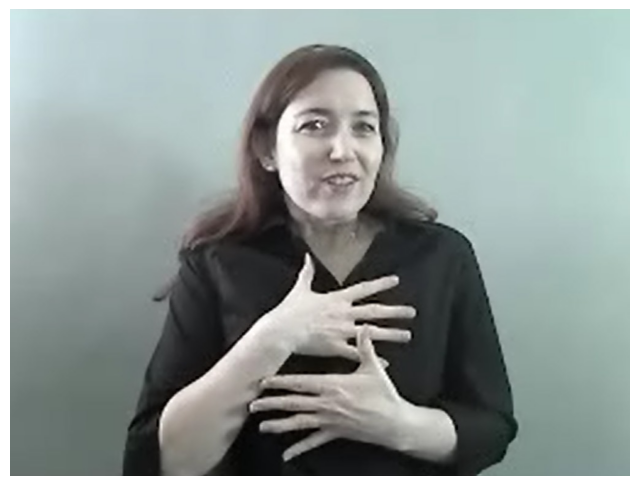

In [ ]:
import requests
from PIL import Image
from io import BytesIO

image_url = '/content/drive/MyDrive/mani.jpg'

img = Image.open(image_url)
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

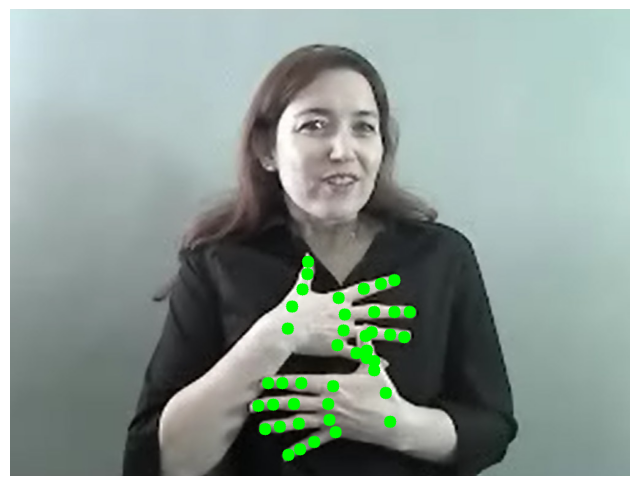

In [ ]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
gloss_counter = Counter(item['gloss'] for item in data)
# Find the 10000 most frequent 'gloss' values
most_common_gloss = [gloss for gloss, count in gloss_counter.most_common(1000)]
k = [item['gloss'] for item in data]
# Filter the list to include only the entries with the most common gloss values
filtered_data = [item for item in data if item['gloss'] in most_common_gloss]

In [ ]:
a = gloss_counter['book']
b = gloss_counter['angle']
print(f'Over-Represented word book: {a} ')
print(f'Under Represented word angle {b}')

Over-Represented word book: 40 
Under Represented word angle 8


In [ ]:
words = []
for item in gloss_counter.keys():
  if gloss_counter[item] >= 10:
    if gloss_counter[item] <= 20:
      words.append(item)

In [ ]:
words = np.array(words)

In [ ]:
np.save('best_words', words)

In [ ]:
try:
    for i in tqdm(range(len(data)), ncols=100):
        video_path = data[i]['video_path']  # Path to the video file
        label = data[i]['gloss']  # Label or gloss
        split = data[i]['split']  # Dataset split: train/val/test
        if split == 'val':
          split = 'train'
        if label in words:
          npy_path = os.path.join('/content/drive/MyDrive/Mydataset_landmarks_1000_labels', split, label)
          os.makedirs(npy_path, exist_ok=True)

          start = data[i]['frame_start']
          end = data[i]['frame_end']

          try:
              video_landmarks = get_video_landmarks(video_path, start, end)
              landmark_file_path = os.path.join(npy_path, f'{os.path.basename(video_path)}.npy')
              np.save(landmark_file_path, video_landmarks)

          except Exception as e:
              print(f"\nError encoding {video_path}\n{e}")
              continue

        else:
          continue

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

100%|█████████████████████████████████████████████████████████| 21082/21082 [53:51<00:00,  6.52it/s]


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import glob
from tqdm import tqdm

class LandmarkDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.landmark_paths = []
        self.labels = []
        self.label_dict = {}
        self.load_landmarks(folder)

    def load_landmarks(self, folder):
        label_folders = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
        self.label_dict = {label: idx for idx, label in enumerate(label_folders)}
        for label in label_folders:
            landmark_files = glob.glob(os.path.join(folder, label, '*.npy'))
            for landmark in landmark_files:
                self.landmark_paths.append(landmark)
                self.labels.append(self.label_dict[label])

    def __len__(self):
        return len(self.landmark_paths)

    def __getitem__(self, idx):
        landmark_path = self.landmark_paths[idx]
        landmarks = np.load(landmark_path)  # Shape is (T, 42, 3)

        if self.transform:
            landmarks = torch.tensor(landmarks, dtype=torch.float32)
            transformed_landmarks = [self.transform(frame) for frame in landmarks]
            if transformed_landmarks:  # Ensure the list is not empty
                landmarks = torch.stack(transformed_landmarks)
            else:
                raise RuntimeError(f"No valid landmarks in file: {landmark_path}")

        label = self.labels[idx]
        return landmarks, label



In [ ]:
def collate_fn(batch):
    landmarks, labels = zip(*batch)
    max_len = max([landmark.size(0) for landmark in landmarks])
    padded_landmarks = []
    masks = []
    for landmark in landmarks:
        pad_size = max_len - landmark.size(0)
        pad = torch.zeros((pad_size, landmark.size(1), landmark.size(2)))
        padded_landmark = torch.cat([landmark, pad], dim=0)
        padded_landmarks.append(padded_landmark)
        mask = [0] * landmark.size(0) + [1] * pad_size
        masks.append(mask)
    padded_landmarks = torch.stack(padded_landmarks, dim=0)
    masks = torch.tensor(masks, dtype=torch.bool)
    labels = torch.tensor(labels)
    return padded_landmarks, labels, masks

In [ ]:
class LandmarkCNN(nn.Module):
    def __init__(self, num_classes, d_model=64, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(LandmarkCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, d_model, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(d_model)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2))

        self.conv2 = nn.Conv2d(d_model, d_model * 2, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(d_model * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))

        self.dropout = nn.Dropout(p=dropout)
        self.fc_input_size = 1280
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x, mask=None):
        x = x.permute(0, 3, 1, 2)  # Change (N, T, 42, 3) to (N, 3, T, 42)
        #x = x.unsqueeze(4)  # Add a channel dimension to make it (N, 3, T, 42, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = x.mean(dim=2)  # Temporal pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, model_save_path='model.pth'):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            predicted_responses_list = []
            actual_responses_list = []

            for inputs, labels, masks in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch + 1}/{num_epochs}'):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                predicted_responses_list.extend(preds.detach().cpu().numpy())
                actual_responses_list.extend(labels.detach().cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), model_save_path)

            correlation = np.corrcoef(predicted_responses_list, actual_responses_list)[0, 1]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Correlation: {correlation:.4f}')

    return train_losses, val_losses, train_acc, val_acc

def main():
    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
    ])

    model_save_path = 'model.pth'
    data_dir = '/content/drive/MyDrive/Mydataset_landmarks_20_labels'
    image_datasets = {x: LandmarkDataset(os.path.join(data_dir, x), transform=data_transforms) for x in ['train', 'test']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn) for x in ['train', 'test']}

    model = LandmarkTransformer(num_classes=len(image_datasets['train'].label_dict))

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    train_losses, val_losses, train_acc, val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=100, model_save_path=model_save_path)
    torch.save({'train_losses': train_losses, 'val_losses': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}, 'losses.pth')
    #plot_losses_and_accuracies()

if __name__ == '__main__':
    main()


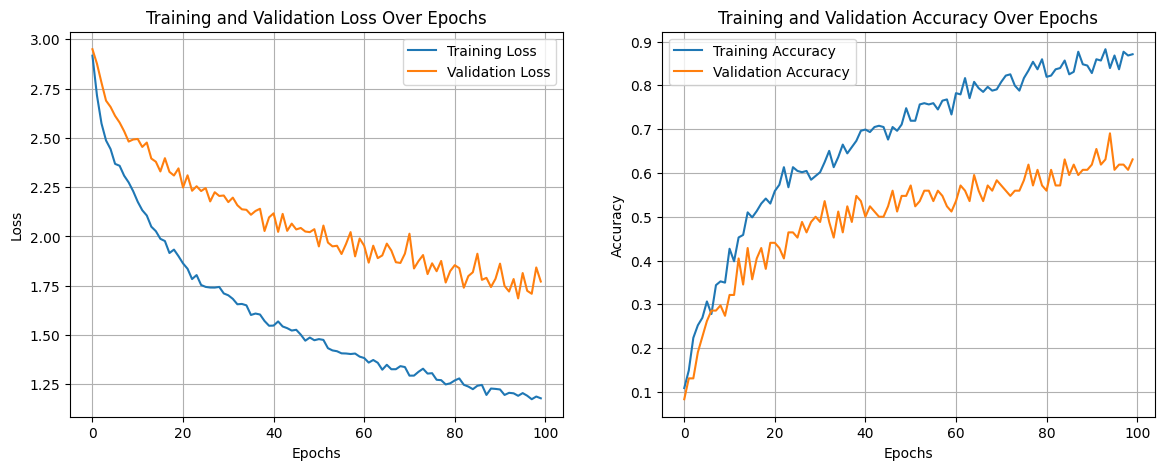

In [ ]:
def plot_losses_and_accuracies():
    metrics = torch.load('losses.pth')
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    train_accuracies = metrics['train_acc']
    val_accuracies = metrics['val_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss Over Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy Over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.show()

if __name__ == '__main__':
    plot_losses_and_accuracies()

In [ ]:
def main():
    data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
    ])

    model_save_path = 'model.pth'
    data_dir = '/content/drive/MyDrive/Mydataset_landmarks_50_labels'
    image_datasets = {x: LandmarkDataset(os.path.join(data_dir, x), transform=data_transforms) for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=256, shuffle=True, num_workers=2, collate_fn=collate_fn) for x in ['train', 'val']}

    model = LandmarkTransformer(num_classes=len(image_datasets['train'].label_dict))

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_acc, val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=100, model_save_path=model_save_path)
    torch.save({'train_losses': train_losses, 'val_losses': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}, 'losses.pth')
    #plot_losses_and_accuracies()

if __name__ == '__main__':
    main()


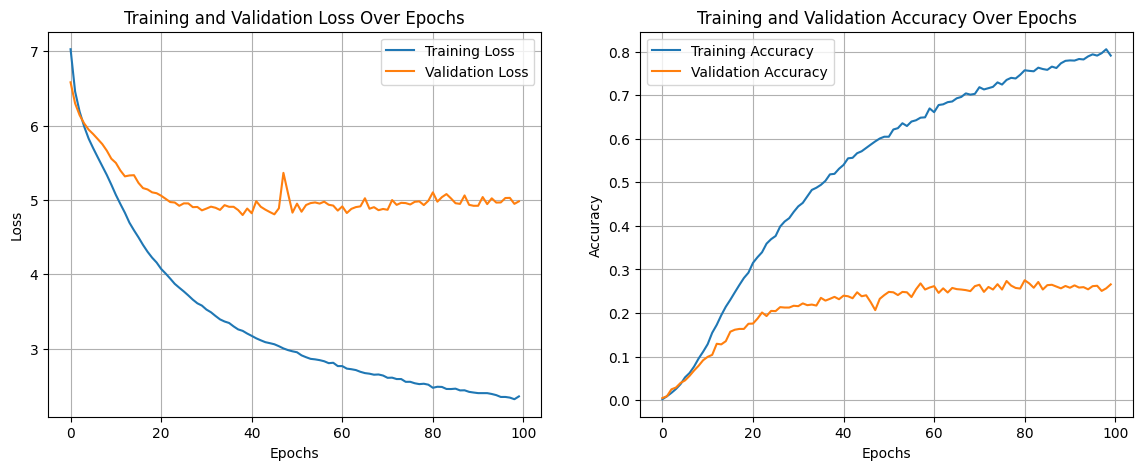

In [ ]:
checkpoint_dir = 'checkpoints_1000_labels_64_0.3'

def load_checkpoint(model, optimizer, checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        print('No checkpoint directory found, starting from scratch')
        return 0, float('inf'), [], [], [], []

    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_')]
    if not checkpoint_files:
        print('No checkpoint files found, starting from scratch')
        return 0, float('inf'), [], [], [], []

    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('_')[2].split('.')[0]))[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    #model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
    print(f'Checkpoint loaded from {checkpoint_path}, starting from epoch {epoch}')
    return epoch, best_val_loss, train_losses, val_losses, train_acc, val_acc

def plot_losses_and_accuracies(checkpoint_dir):
    _, _, train_losses, val_losses, train_acc, val_acc = load_checkpoint(None, None, checkpoint_dir)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss Over Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy Over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.show()

if __name__ == '__main__':
    plot_losses_and_accuracies(checkpoint_dir)
